In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.densenet import DenseNet169,preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imagedir = "Datasets/ByFamilyPortexNoLegend"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:         allaple	Number of images: 362
Label: 1	Family:           alman	Number of images: 325
Label: 2	Family:          autoit	Number of images: 261
Label: 3	Family:            daws	Number of images: 466
Label: 4	Family:            delf	Number of images: 359
Label: 5	Family:         gamarue	Number of images: 259
Label: 6	Family:          ibryte	Number of images: 347
Label: 7	Family:          loring	Number of images: 285
Label: 8	Family:          mydoom	Number of images: 578
Label: 9	Family:          qukart	Number of images: 253
Label:10	Family:          ramnit	Number of images: 506
Label:11	Family:          sality	Number of images: 1401
Label:12	Family:          simbot	Number of images: 1148
Label:13	Family:       softpulse	Number of images: 912
Label:14	Family:          viking	Number of images: 183
Label:15	Family:         virlock	Number of images: 373
Label:16	Family:          vobfus	Number of images: 405
Label:17	Family:          wapomi	Number of images: 345
Label:18

In [4]:
X.shape

(10136, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [ ]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Training the model from scratch
num_epochs=100
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
history = []
checkpointer = ModelCheckpoint(filepath='weights-portex_nolegend-densenet169-Adam-%depochs-fromscratch.h5' %(num_epochs), monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix

model = DenseNet169(weights=None, input_shape=image_shape, include_top=True, classes=num_classes)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]
    
    model.set_weights(init_weights)

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

Train on 9112 samples, validate on 1024 samples
Epoch 1/100
9112/9112 [==============================] - 193s 21ms/step - loss: 0.8336 - acc: 0.7687 - val_loss: 2.5583 - val_acc: 0.4912
Epoch 2/100
9112/9112 [==============================] - 133s 15ms/step - loss: 0.4167 - acc: 0.8793 - val_loss: 0.9216 - val_acc: 0.7334
Epoch 3/100
9112/9112 [==============================] - 137s 15ms/step - loss: 0.2805 - acc: 0.9194 - val_loss: 1.3445 - val_acc: 0.5898
Epoch 4/100
9112/9112 [==============================] - 133s 15ms/step - loss: 0.2527 - acc: 0.9248 - val_loss: 0.5414 - val_acc: 0.8545
Epoch 5/100
9112/9112 [==============================] - 131s 14ms/step - loss: 0.1907 - acc: 0.9445 - val_loss: 0.4788 - val_acc: 0.7920
Epoch 6/100
9112/9112 [==============================] - 134s 15ms/step - loss: 0.1649 - acc: 0.9503 - val_loss: 0.3318 - val_acc: 0.9209
Epoch 7/100
9112/9112 [==============================] - 131s 14ms/step - loss: 0.1412 - acc: 0.9580 - val_loss: 0.9822 - va

Epoch 92/100
9120/9120 [==============================] - 130s 14ms/step - loss: 0.0128 - acc: 0.9962 - val_loss: 0.6948 - val_acc: 0.9104
Epoch 93/100
9120/9120 [==============================] - 131s 14ms/step - loss: 0.0137 - acc: 0.9962 - val_loss: 0.2591 - val_acc: 0.9685
Epoch 94/100
9120/9120 [==============================] - 131s 14ms/step - loss: 0.0144 - acc: 0.9955 - val_loss: 0.2263 - val_acc: 0.9705
Epoch 95/100
9120/9120 [==============================] - 129s 14ms/step - loss: 0.0098 - acc: 0.9971 - val_loss: 0.2589 - val_acc: 0.9675
Epoch 96/100
9120/9120 [==============================] - 131s 14ms/step - loss: 0.0017 - acc: 0.9997 - val_loss: 0.2356 - val_acc: 0.9685
Epoch 97/100
9120/9120 [==============================] - 131s 14ms/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.2202 - val_acc: 0.9724
Epoch 98/100
9120/9120 [==============================] - 131s 14ms/step - loss: 0.0014 - acc: 0.9997 - val_loss: 0.2118 - val_acc: 0.9734
Epoch 99/100
9120/9120 [===

Epoch 52/100
9125/9125 [==============================] - 130s 14ms/step - loss: 0.0175 - acc: 0.9948 - val_loss: 2.4493 - val_acc: 0.7319
Epoch 53/100
9125/9125 [==============================] - 131s 14ms/step - loss: 0.0205 - acc: 0.9922 - val_loss: 3.9799 - val_acc: 0.5579
Epoch 54/100
9125/9125 [==============================] - 131s 14ms/step - loss: 0.0258 - acc: 0.9921 - val_loss: 0.8879 - val_acc: 0.7735
Epoch 55/100
9125/9125 [==============================] - 131s 14ms/step - loss: 0.0149 - acc: 0.9957 - val_loss: 0.1411 - val_acc: 0.9782
Epoch 56/100
9125/9125 [==============================] - 130s 14ms/step - loss: 0.0048 - acc: 0.9987 - val_loss: 0.2262 - val_acc: 0.9624
Epoch 57/100
9125/9125 [==============================] - 130s 14ms/step - loss: 0.0098 - acc: 0.9972 - val_loss: 0.2427 - val_acc: 0.9565
Epoch 58/100
9125/9125 [==============================] - 130s 14ms/step - loss: 0.0165 - acc: 0.9952 - val_loss: 3.4127 - val_acc: 0.6548
Epoch 59/100
9125/9125 [===

Epoch 10/100
9127/9127 [==============================] - 130s 14ms/step - loss: 0.1586 - acc: 0.9503 - val_loss: 0.3874 - val_acc: 0.8979
Epoch 11/100
9127/9127 [==============================] - 131s 14ms/step - loss: 0.1273 - acc: 0.9618 - val_loss: 0.3279 - val_acc: 0.9187
Epoch 12/100
9127/9127 [==============================] - 131s 14ms/step - loss: 0.1160 - acc: 0.9646 - val_loss: 0.2620 - val_acc: 0.9346
Epoch 13/100
9127/9127 [==============================] - 131s 14ms/step - loss: 0.1060 - acc: 0.9661 - val_loss: 2.8312 - val_acc: 0.5798
Epoch 14/100
9127/9127 [==============================] - 131s 14ms/step - loss: 0.0971 - acc: 0.9716 - val_loss: 0.4343 - val_acc: 0.9009
Epoch 15/100
9127/9127 [==============================] - 130s 14ms/step - loss: 0.1008 - acc: 0.9684 - val_loss: 0.2012 - val_acc: 0.9504
Epoch 16/100
9127/9127 [==============================] - 131s 14ms/step - loss: 0.0708 - acc: 0.9776 - val_loss: 0.3346 - val_acc: 0.9207
Epoch 17/100
9127/9127 [===

Epoch 69/100
9127/9127 [==============================] - 131s 14ms/step - loss: 0.0078 - acc: 0.9982 - val_loss: 0.3311 - val_acc: 0.9524
Epoch 70/100
9127/9127 [==============================] - 131s 14ms/step - loss: 0.0343 - acc: 0.9901 - val_loss: 0.2692 - val_acc: 0.9495
Epoch 71/100
9127/9127 [==============================] - 130s 14ms/step - loss: 0.0128 - acc: 0.9957 - val_loss: 0.2506 - val_acc: 0.9604
Epoch 72/100
9127/9127 [==============================] - 131s 14ms/step - loss: 0.0080 - acc: 0.9985 - val_loss: 0.2399 - val_acc: 0.9623
Epoch 73/100
9127/9127 [==============================] - 130s 14ms/step - loss: 0.0038 - acc: 0.9997 - val_loss: 0.2144 - val_acc: 0.9673
Epoch 74/100
9127/9127 [==============================] - 130s 14ms/step - loss: 0.0031 - acc: 0.9997 - val_loss: 0.2143 - val_acc: 0.9683
Epoch 75/100
9127/9127 [==============================] - 130s 14ms/step - loss: 0.0158 - acc: 0.9961 - val_loss: 0.4683 - val_acc: 0.9148
Epoch 76/100
9127/9127 [===

Epoch 27/100
9128/9128 [==============================] - 130s 14ms/step - loss: 0.0308 - acc: 0.9900 - val_loss: 0.6260 - val_acc: 0.8304
Epoch 28/100
9128/9128 [==============================] - 131s 14ms/step - loss: 0.0558 - acc: 0.9818 - val_loss: 0.3206 - val_acc: 0.9375
Epoch 29/100
9128/9128 [==============================] - 131s 14ms/step - loss: 0.0437 - acc: 0.9849 - val_loss: 0.9727 - val_acc: 0.8056
Epoch 30/100
9128/9128 [==============================] - 131s 14ms/step - loss: 0.0343 - acc: 0.9893 - val_loss: 0.2932 - val_acc: 0.9415
Epoch 31/100
9128/9128 [==============================] - 131s 14ms/step - loss: 0.0372 - acc: 0.9870 - val_loss: 2.1675 - val_acc: 0.7560
Epoch 32/100
9128/9128 [==============================] - 131s 14ms/step - loss: 0.0234 - acc: 0.9915 - val_loss: 0.2498 - val_acc: 0.9494
Epoch 33/100
9128/9128 [==============================] - 131s 14ms/step - loss: 0.0424 - acc: 0.9887 - val_loss: 1.1890 - val_acc: 0.8085
Epoch 34/100
9128/9128 [===

Epoch 86/100
9128/9128 [==============================] - 131s 14ms/step - loss: 0.0064 - acc: 0.9980 - val_loss: 0.4675 - val_acc: 0.9296
Epoch 87/100
9128/9128 [==============================] - 131s 14ms/step - loss: 0.0045 - acc: 0.9986 - val_loss: 0.2700 - val_acc: 0.9613
Epoch 88/100
9128/9128 [==============================] - 131s 14ms/step - loss: 0.0157 - acc: 0.9956 - val_loss: 0.2821 - val_acc: 0.9514
Epoch 89/100
9128/9128 [==============================] - 131s 14ms/step - loss: 0.0230 - acc: 0.9940 - val_loss: 0.2995 - val_acc: 0.9563
Epoch 90/100
9128/9128 [==============================] - 131s 14ms/step - loss: 0.0062 - acc: 0.9977 - val_loss: 0.2602 - val_acc: 0.9583
Epoch 91/100
9128/9128 [==============================] - 131s 14ms/step - loss: 0.0038 - acc: 0.9990 - val_loss: 0.2222 - val_acc: 0.9663
Epoch 92/100
9128/9128 [==============================] - 130s 14ms/step - loss: 0.0126 - acc: 0.9966 - val_loss: 0.2406 - val_acc: 0.9633
Epoch 93/100
9128/9128 [===

Epoch 44/100
9130/9130 [==============================] - 131s 14ms/step - loss: 0.0249 - acc: 0.9918 - val_loss: 0.2679 - val_acc: 0.9453
Epoch 45/100
9130/9130 [==============================] - 132s 14ms/step - loss: 0.0151 - acc: 0.9962 - val_loss: 0.2751 - val_acc: 0.9563
Epoch 46/100
9130/9130 [==============================] - 131s 14ms/step - loss: 0.0069 - acc: 0.9984 - val_loss: 0.2111 - val_acc: 0.9692
Epoch 47/100
9130/9130 [==============================] - 132s 14ms/step - loss: 0.0047 - acc: 0.9985 - val_loss: 0.2511 - val_acc: 0.9632
Epoch 48/100
9130/9130 [==============================] - 132s 14ms/step - loss: 0.0178 - acc: 0.9944 - val_loss: 0.3610 - val_acc: 0.9523
Epoch 49/100
6080/9130 [==================>...........] - ETA: 41s - loss: 0.0648 - acc: 0.9809

In [21]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9393


In [22]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

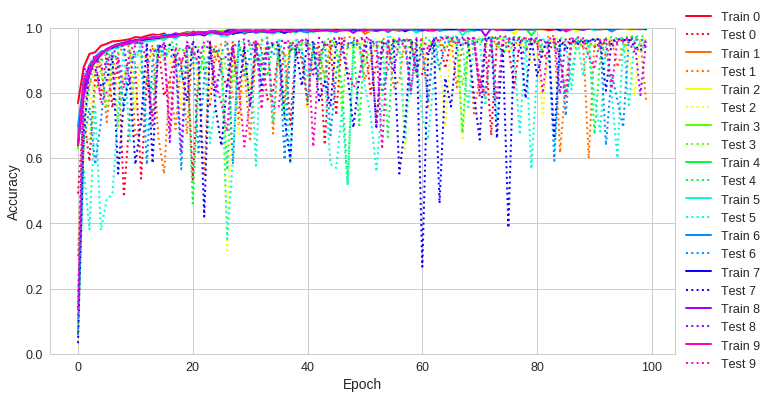

In [23]:
plot_acc(history)

In [24]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

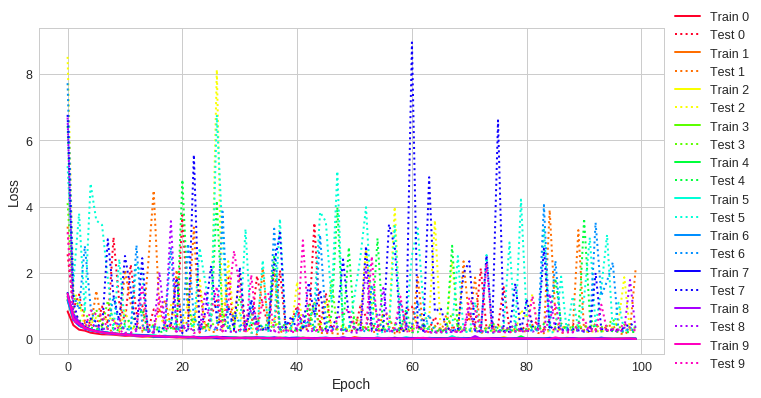

In [25]:
plot_loss(history)

Plotting the confusion matrix


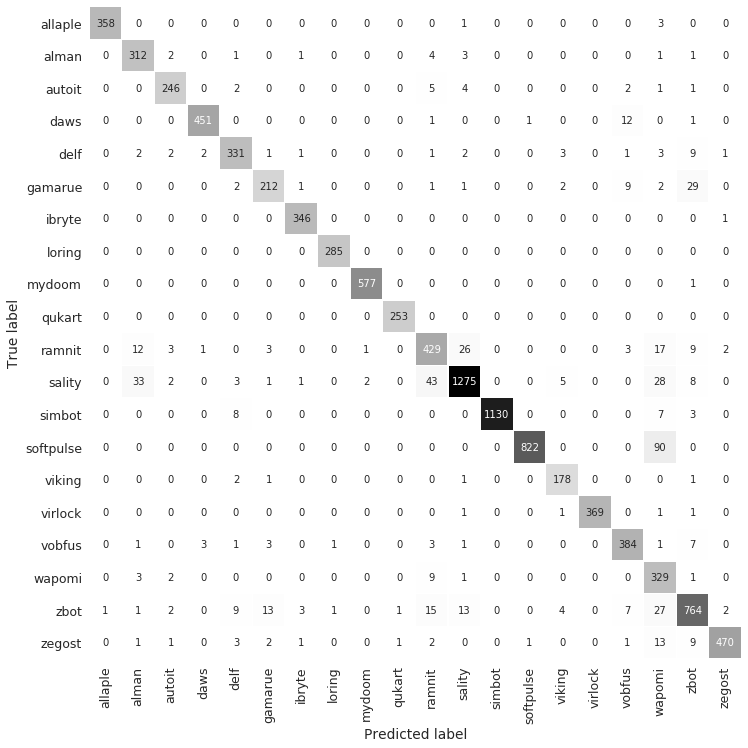

In [26]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


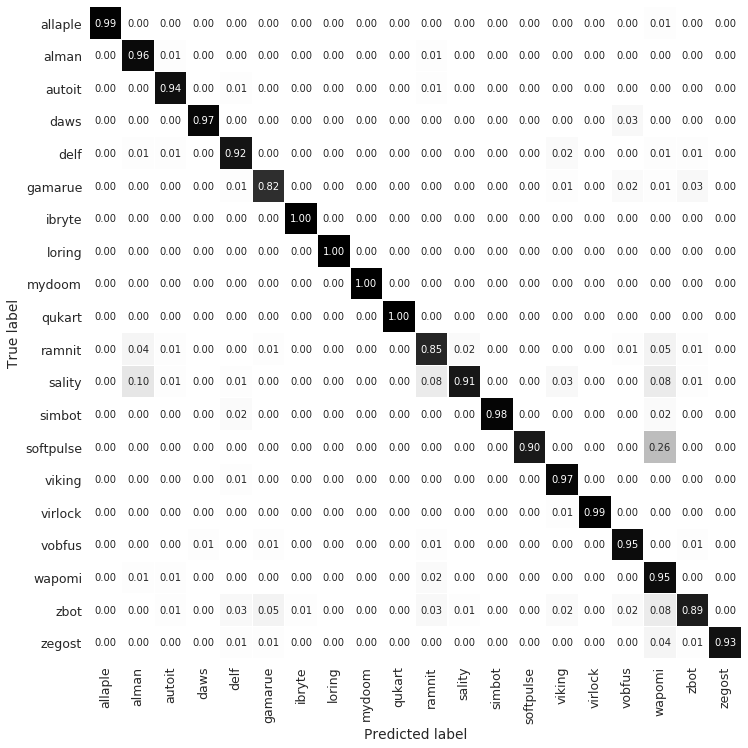

In [27]:
import seaborn as sns

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(20, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 10}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [28]:
for h in history:
    print(h.history)

{'acc': [0.7686567165225718, 0.8792800703417114, 0.919446883283235, 0.9248244074272209, 0.9444688324137044, 0.9502853380158033, 0.957967515469016, 0.9589552239852583, 0.9615891132572432, 0.9645522389106315, 0.9710272169092227, 0.9694907813871817, 0.9749780509218613, 0.9792581211589113, 0.9770632134497008, 0.9821115013169447, 0.9712467077429405, 0.9773924496217816, 0.9817822652495253, 0.9859525900958818, 0.9841966637401229, 0.9870500438981563, 0.9862818262679625, 0.9837576821773486, 0.9828797190517998, 0.9865013169446883, 0.9916593503072871, 0.994622475856014, 0.9897936786654961, 0.9813432835820896, 0.9905618964003512, 0.9889157155399473, 0.9940737489025461, 0.9912203687445127, 0.9856233538191396, 0.9924275680421423, 0.9941834942932397, 0.9926470588235294, 0.9947322212467077, 0.9939640035118525, 0.9925373134328358, 0.9948419666374012, 0.9934152765583846, 0.9955004389815628, 0.9969271290605795, 0.9930860403863038, 0.990342405618964, 0.9944029850746269, 0.9980245829675154, 0.9996707638279

In [29]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

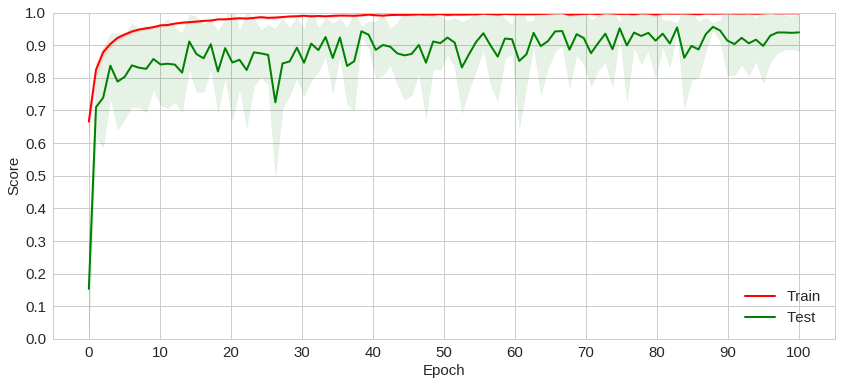

In [30]:
plot_mean_acc(history)

In [31]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

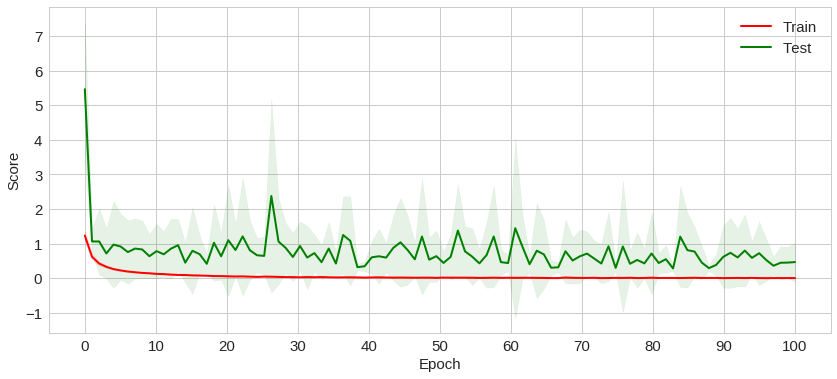

In [32]:
plot_mean_loss(history)

In [34]:
hist = [{'acc': [0.7686567165225718, 0.8792800703417114, 0.919446883283235, 0.9248244074272209, 0.9444688324137044, 0.9502853380158033, 0.957967515469016, 0.9589552239852583, 0.9615891132572432, 0.9645522389106315, 0.9710272169092227, 0.9694907813871817, 0.9749780509218613, 0.9792581211589113, 0.9770632134497008, 0.9821115013169447, 0.9712467077429405, 0.9773924496217816, 0.9817822652495253, 0.9859525900958818, 0.9841966637401229, 0.9870500438981563, 0.9862818262679625, 0.9837576821773486, 0.9828797190517998, 0.9865013169446883, 0.9916593503072871, 0.994622475856014, 0.9897936786654961, 0.9813432835820896, 0.9905618964003512, 0.9889157155399473, 0.9940737489025461, 0.9912203687445127, 0.9856233538191396, 0.9924275680421423, 0.9941834942932397, 0.9926470588235294, 0.9947322212467077, 0.9939640035118525, 0.9925373134328358, 0.9948419666374012, 0.9934152765583846, 0.9955004389815628, 0.9969271290605795, 0.9930860403863038, 0.990342405618964, 0.9944029850746269, 0.9980245829675154, 0.9996707638279192, 0.9996707638279192, 0.9914398595258999, 0.990342405618964, 0.9967076383838537, 0.9955004390862241, 0.9930860403863038, 0.9969271290605795, 0.999451273046532, 0.9997805092186128, 0.9915496049165935, 0.9933055311676909, 0.9981343283582089, 0.9968173837745472, 0.9960491659350307, 0.9968173836698858, 0.9969271290605795, 0.9973661106233538, 0.9955004389815628, 0.9980245829675154, 0.9978050921861282, 0.9978050921861282, 0.9967076382791923, 0.9949517120280948, 0.9971466198419666, 0.9964881474978051, 0.9960491659350307, 0.9950614574187884, 0.9972563652326603, 0.9993415276558385, 0.9996707638279192, 0.999451273046532, 0.9958296751536435, 0.9918788410886743, 0.9941834942932397, 0.997585601404741, 0.9985733099209834, 0.9981343283582089, 0.9986830553116769, 0.9971466198419666, 0.9973661106233538, 0.9961589113257243, 0.9979148375768218, 0.9982440737489026, 0.9993415276558385, 0.9997805092186128, 0.9997805092186128, 0.9997805092186128, 0.9997805092186128, 0.9997805092186128, 0.9996707638279192], 'val_acc': [0.4912109375, 0.7333984375, 0.58984375, 0.8544921875, 0.7919921875, 0.9208984375, 0.75390625, 0.89453125, 0.4814453125, 0.7275390625, 0.87890625, 0.537109375, 0.8408203125, 0.728515625, 0.9501953125, 0.791015625, 0.84375, 0.9208984375, 0.89453125, 0.927734375, 0.5341796875, 0.8720703125, 0.8740234375, 0.763671875, 0.943359375, 0.86328125, 0.814453125, 0.9599609375, 0.6982421875, 0.951171875, 0.947265625, 0.9580078125, 0.9345703125, 0.779296875, 0.806640625, 0.9267578125, 0.923828125, 0.7021484375, 0.94921875, 0.9013671875, 0.7626953125, 0.951171875, 0.94140625, 0.640625, 0.9453125, 0.7314453125, 0.9697265625, 0.9462890625, 0.9560546875, 0.9638671875, 0.96484375, 0.796875, 0.892578125, 0.9345703125, 0.9189453125, 0.958984375, 0.962890625, 0.9609375, 0.9619140625, 0.853515625, 0.857421875, 0.9443359375, 0.94140625, 0.9599609375, 0.875, 0.9580078125, 0.9560546875, 0.9482421875, 0.955078125, 0.9599609375, 0.810546875, 0.9443359375, 0.669921875, 0.958984375, 0.947265625, 0.943359375, 0.8154296875, 0.9580078125, 0.966796875, 0.9658203125, 0.9462890625, 0.90625, 0.9248046875, 0.958984375, 0.955078125, 0.953125, 0.9580078125, 0.951171875, 0.94140625, 0.9560546875, 0.9404296875, 0.9541015625, 0.955078125, 0.9580078125, 0.9599609375, 0.9619140625, 0.9619140625, 0.962890625, 0.9609375, 0.9619140625], 'val_loss': [2.558278511656681, 0.9215518660348607, 1.3444627874268917, 0.5413799899706646, 0.4787737029255368, 0.33179458757254565, 0.9822423490848564, 0.45299380829237634, 3.0691996883834456, 1.1041406805177303, 0.5220993809805492, 2.2479806252813432, 0.7728251568678388, 1.0161026576997756, 0.23542243282992104, 0.8943331025075167, 0.7988339147239572, 0.3910878901389765, 0.38551930304538473, 0.27922775837051006, 3.7357988866042433, 0.7400571562880032, 0.47463153690508264, 1.5379603013861924, 0.31075475381415174, 0.7005358744835348, 1.1635282992401814, 0.23241033887541107, 1.9215401090658588, 0.24751365378133983, 0.27056042296501914, 0.24809123511316855, 0.33610307783089866, 1.9080309163859965, 1.0080117800374637, 0.40005578355342397, 0.3725944787208135, 2.070462709293011, 0.3167781068197115, 0.5221723304982833, 0.999801991267951, 0.27976868898798557, 0.29679981908311515, 3.5035009326857924, 0.3537330104963612, 1.392534024078632, 0.2336870313003665, 0.30831338624268056, 0.27124421920259545, 0.2451904120813424, 0.2553934985829627, 0.9853203811808853, 0.6794104533647101, 0.37500098602308185, 0.432076636451626, 0.23447294482450598, 0.2635689759623201, 0.22412749292732714, 0.23796986382429042, 0.8211193432039181, 0.9782979970307384, 0.3689601623754015, 0.37915095657972486, 0.3057021724968614, 0.668794556641013, 0.2589975984894961, 0.2758574659017894, 0.343369507278954, 0.34747660008916803, 0.2686652235143221, 0.7809128258968485, 0.3662506348849077, 2.13122484171193, 0.31523500324593634, 0.3667866451942903, 0.4064546891650034, 1.5624908675203883, 0.2943627738698025, 0.2570454876362991, 0.2537893544799332, 0.42896735426802035, 0.5617631840687132, 0.4474294057215502, 0.2550383743682829, 0.2751800159922104, 0.284856909584315, 0.31280682285854766, 0.4090440246056328, 0.47299378149696825, 0.28165880098546126, 0.3939571593539437, 0.3378034645203334, 0.29257877349184724, 0.32628701752338474, 0.308531683083034, 0.2838866464705885, 0.2771540359991467, 0.28677000334938807, 0.2763731954588633, 0.28143873745083026], 'loss': [0.8336349857334927, 0.41665326253796375, 0.2804583128577685, 0.25269964379213483, 0.19074105592060236, 0.1649262397545958, 0.14124073683594118, 0.1386119548421062, 0.13004891757213097, 0.1122277912857948, 0.096278004181474, 0.10171263174524267, 0.08281573056201659, 0.06993035614981927, 0.07634381353904193, 0.05654986831461774, 0.09743240683505523, 0.06997956881091928, 0.057283201463409324, 0.04645898901849055, 0.04789371229800182, 0.04182075823777207, 0.04172874704963888, 0.04588294705078398, 0.052540541501818805, 0.04213618583108656, 0.02645560286426978, 0.015408916293454943, 0.031810465458681075, 0.055513001893615535, 0.030490104372082057, 0.03533335642935544, 0.01806999063909874, 0.02365942275575724, 0.045147970076304916, 0.022953312997848814, 0.01782827372155003, 0.022466266659710167, 0.017600632669663555, 0.022108947437029697, 0.025386710045723793, 0.016175549032214995, 0.020598231060970324, 0.01594661935605129, 0.010473252132808924, 0.022997097120539642, 0.02861087295534515, 0.020116488354161032, 0.006357659660933821, 0.002083019216452613, 0.0017940561650730488, 0.03159253843646811, 0.029387032302390512, 0.012573506968320425, 0.016671912305701114, 0.02099310925339849, 0.009341000956695523, 0.0029735711386153435, 0.001749943186282839, 0.026449867558879226, 0.024169194713355813, 0.006934473019317744, 0.009915371977405335, 0.017373737745218883, 0.013005602628460579, 0.01120169158716144, 0.009018593176140415, 0.01716155610720195, 0.006768516078954825, 0.0063082758285886815, 0.007462728300551876, 0.012582104412040863, 0.01696463378567779, 0.008241978492657499, 0.00965382956452739, 0.013372305537022783, 0.014591212731983041, 0.008986300159098116, 0.002036563465758347, 0.0015237981533641348, 0.0023164255222549003, 0.012840432303829715, 0.026709157861026848, 0.017625754287375787, 0.007119274834693912, 0.004437670837648557, 0.005267962752496332, 0.004157907738841009, 0.012253430277690427, 0.007046740593791778, 0.015077295571544925, 0.006365739231355424, 0.00609011018106343, 0.0023793674044458074, 0.0014510436911457684, 0.0011630061869736057, 0.000950766187627986, 0.0009321055602909223, 0.0011223753853349986, 0.0011872809953963662]},
{'acc': [0.6720430108965659, 0.83443054662139, 0.879635725454042, 0.9022383148638282, 0.9159534783485769, 0.9320825104366041, 0.9404213299138101, 0.9473337723101234, 0.9488698705288567, 0.9556725918004093, 0.9622558700899715, 0.956221198156682, 0.9656572306472689, 0.9686197059468948, 0.967851656791749, 0.9704849681808208, 0.9738863287250384, 0.9737766074171604, 0.9769585253456221, 0.9783849024395945, 0.9768488041293028, 0.9805793285055958, 0.9803598858898398, 0.9799210006583279, 0.9847487382049595, 0.9869431644540778, 0.9856265086679833, 0.9877112135176651, 0.9854070661437859, 0.9940750494661471, 0.9884792627643697, 0.9897959183673469, 0.9867237217467633, 0.989247311827957, 0.9916611806012727, 0.989137590520079, 0.9906736888303709, 0.9871626069782752, 0.9913320166776388, 0.9937458854509545, 0.9918806232170287, 0.9895764757515909, 0.989357033135835, 0.9928681150794892, 0.9915514592933948, 0.9951722624533684, 0.9974764099188063, 0.9982444590739522, 0.9983541803818301, 0.9981347377660742, 0.9806890498134738, 0.9907834101382489, 0.9967083608552189, 0.9973666886109283, 0.9971472459951722, 0.9926486723721747, 0.989466754443713, 0.9955014263770025, 0.9939653280667106, 0.9953917050691244, 0.9972569673030502, 0.9985736229975861, 0.9926486723721747, 0.9941847706824666, 0.9940750493745886, 0.9978055738424402, 0.9972569673030502, 0.9952819837612464, 0.9944042132982225, 0.9967083607636603, 0.9965986394557823, 0.9972569673946089, 0.9983541803818301, 0.9986833443054641, 0.9927583936800527, 0.995940311700073, 0.9941847706824666, 0.9972569673030502, 0.9962694755321484, 0.9989027869212201, 0.9955014263770025, 0.994623656005537, 0.9976958525345622, 0.9994513934606101, 0.9974764100103648, 0.9934167215273206, 0.9969278033794163, 0.999231950844854, 0.9969278033794163, 0.9963791968400263, 0.9974764099188063, 0.9982444590739522, 0.9980250164581962, 0.9948430985297345, 0.9960500330079509, 0.9970375247788529, 0.9973666886109283, 0.9995611147684881, 0.9989027869212201, 0.9969278033794163], 'val_acc': [0.299412915851272, 0.7641878683273107, 0.8287671232876712, 0.8590998043052838, 0.9060665371366676, 0.7103718213605787, 0.8786692759295499, 0.9158512720156555, 0.9481409001956947, 0.9422700587084148, 0.6643835616438356, 0.6937377707132388, 0.863013698630137, 0.9471624266144814, 0.6643835630435533, 0.5518591012040229, 0.8414872798434442, 0.6888454025738859, 0.898238747553816, 0.6741682988556864, 0.9461839530332681, 0.8688845401174168, 0.5440313125543165, 0.9579256360078278, 0.8982387484869612, 0.9510763218724798, 0.958904109589041, 0.7818003923225776, 0.7798434456267236, 0.8776908023483366, 0.650684932906567, 0.9305283779500748, 0.958904109589041, 0.9677103718199609, 0.6751467724368997, 0.949119373776908, 0.7729941305582304, 0.9598825831702544, 0.9412915851272016, 0.9481409001956947, 0.9461839530332681, 0.9168297455968689, 0.9227005889504389, 0.8493150684931506, 0.9628180039138943, 0.9706457925636007, 0.9677103718199609, 0.9706457925636007, 0.9726027397260274, 0.9471624266144814, 0.840508807195376, 0.898238747553816, 0.9393346379647749, 0.9667318982387475, 0.961839530332681, 0.8170254412462566, 0.8385518590998043, 0.9677103718199609, 0.9569471624266145, 0.9569471624266145, 0.9657534246575342, 0.7583170276565327, 0.961839530332681, 0.9667318982387475, 0.9295499021526419, 0.9657534246575342, 0.8170254412462566, 0.952054794520548, 0.9686888454011742, 0.7367906082866243, 0.8444227005870841, 0.7808219192079369, 0.974559686888454, 0.9412915851272016, 0.9442270058708415, 0.9608610567514677, 0.9422700587084148, 0.9716242661448141, 0.9510763209393346, 0.9608610567514677, 0.9647749510763209, 0.9256360078277887, 0.9735812133072407, 0.974559686888454, 0.6164383577973875, 0.8356164392893095, 0.9686888454011742, 0.9637964774951077, 0.9628180039138943, 0.598825833335548, 0.9579256360078278, 0.9637964774951077, 0.9080234833659491, 0.9637964774951077, 0.8786692759295499, 0.9363992172211351, 0.9686888454011742, 0.9735812133072407, 0.958904109589041, 0.7759295521183723], 'val_loss': [3.3932795406787597, 0.8900807912364864, 0.5592889202915409, 0.47958073349814356, 0.33779799983947884, 1.4566186168349535, 0.43543084379588115, 0.3497563866527529, 0.1711316764413483, 0.20587631287973615, 2.084734112441671, 1.0684276310136493, 0.5347046563492945, 0.2186364567037371, 2.1694196900642164, 4.48128292336331, 0.7856970592119427, 1.1753709717114218, 0.3574158105276591, 2.08956605691368, 0.217822224292867, 0.5880353647045455, 3.3656441777764132, 0.18695702876151496, 0.4220576419362, 0.21241006636916918, 0.21509338013186352, 1.130164474662377, 1.0009856145489968, 0.5851932862547313, 1.9507727217384379, 0.2746763362762484, 0.19199530356681754, 0.13705158112866667, 2.1373734326996483, 0.26987622633153274, 2.097738088290171, 0.1976811211575714, 0.2871290968190759, 0.2579008697405995, 0.2526961885032435, 0.40609492901504957, 0.36730442312583805, 1.1383765393870524, 0.18249185934613896, 0.17836108914521268, 0.17910496681089863, 0.15705117514352585, 0.15959488551984685, 0.33985052489682815, 0.5850939285010099, 0.531557765561818, 0.31071099095629195, 0.22088614980607071, 0.2076084868395924, 0.778076564878546, 0.7095278012280926, 0.17100805211513434, 0.2075933657820359, 0.28112442682586064, 0.20803114667570802, 1.8722338290801253, 0.26600143659380204, 0.20209826907362435, 0.4017732803433778, 0.17107671543476544, 0.7318985241317728, 0.33517833582257867, 0.1788664387514155, 2.344347646616676, 0.5201616063130295, 1.8559668765800958, 0.14897462739766495, 0.37814190418241084, 0.32525489911996935, 0.22248382036942296, 0.3611938032644593, 0.18994192567442114, 0.3208332478155722, 0.24373656284556475, 0.22612434698584616, 0.42715019173419666, 0.1805122776060516, 0.17327014787837022, 3.8956671339305258, 0.6891873205450435, 0.17971241201724955, 0.2041954026386061, 0.22236341537453058, 3.2884927136559043, 0.22912990639584266, 0.21172443537659658, 0.4733268680644701, 0.24742603545950412, 0.39145094529212326, 0.41074178348019375, 0.17307001554622917, 0.1410911964673519, 0.2646023520510763, 2.1504458470759404], 'loss': [1.1739660669424723, 0.5890310947272975, 0.41866923475935186, 0.3324784336479604, 0.2722026876760256, 0.23649216199198494, 0.20757383329678136, 0.17743187175688838, 0.1639786244674353, 0.14881060405869168, 0.12980537349102736, 0.14097436617864495, 0.112701634805513, 0.10228644732597603, 0.10818095837627975, 0.09343164493627185, 0.08589894135803677, 0.08184482255001876, 0.07487187860032885, 0.0678382920281541, 0.06946933144629525, 0.06588194126662604, 0.05921208345659677, 0.062363609706131556, 0.04443532164245991, 0.04257697641318355, 0.042776137233983796, 0.042313119484958174, 0.04334649837129096, 0.01755323651550372, 0.03779551958083201, 0.0368014637802151, 0.039579422575335185, 0.031004593572710123, 0.02556000415609043, 0.03409262948563424, 0.03074922187893823, 0.03871727057768713, 0.027548211884159575, 0.020655720037577954, 0.02254310047081732, 0.030585649698053642, 0.03538565801472205, 0.020690657337708532, 0.030939097397294266, 0.015643665280511095, 0.009690237582886991, 0.00653483421825195, 0.005714496275445847, 0.006258811265617361, 0.06038602016003656, 0.028476350745550504, 0.008487781541147283, 0.00858550243574172, 0.009001183426249426, 0.02093884424447635, 0.034263180450374395, 0.015716521887603824, 0.018912044741716053, 0.016637684453756192, 0.009532416476254212, 0.0049564358655938235, 0.022618118976678408, 0.017422269937798347, 0.01797474845309384, 0.007310246932572568, 0.009929556350271122, 0.017702531100011652, 0.01655938586594995, 0.013976330524456595, 0.01159285520464139, 0.00897950172381245, 0.005196816155952071, 0.004772922569572177, 0.025755310917840755, 0.013605375497202622, 0.015878614306463864, 0.0077297007049886785, 0.011669618688023735, 0.0038594585659761337, 0.014016623279087433, 0.015661653064629324, 0.005499513750298156, 0.0022995463846430956, 0.008028199641315983, 0.019618565612567914, 0.008908514625837638, 0.004049350832533002, 0.010838049174045818, 0.011268984617896912, 0.00818080036264198, 0.004841160638605798, 0.005078164757107612, 0.019216595522152127, 0.014029278928222203, 0.009293354956875463, 0.007792886357586737, 0.001673216534056941, 0.0050274126459094745, 0.01356311804837126]},
{'acc': [0.6502852129434065, 0.8224001755678847, 0.8824045635619253, 0.9017112769804382, 0.9232119351115442, 0.9323168057734216, 0.9424089512944274, 0.9480035104161556, 0.9535980694332683, 0.9569986836331724, 0.9607283896968887, 0.96028960075437, 0.9677490127771871, 0.9689556823691133, 0.9731241772707327, 0.9754278192712634, 0.9804738921625356, 0.9801448004033388, 0.9787187362878456, 0.9789381308114126, 0.9879333040807372, 0.983435717419921, 0.98376480912681, 0.9780605528740676, 0.9887011848347602, 0.9904563405002194, 0.9817902588854761, 0.9874945151382185, 0.9911145239663051, 0.9903466432645898, 0.9906757349714788, 0.9887011847301448, 0.9884817902588855, 0.9892496709082931, 0.992101799086972, 0.9921017990346643, 0.9880430013163668, 0.9910048266783678, 0.9975866608161474, 0.9942957437472576, 0.9877139096617855, 0.9890302764893415, 0.9941860465116279, 0.9914436156731941, 0.9946248354541466, 0.9982448442299254, 0.9962702939885915, 0.9881526985519965, 0.9919921017990346, 0.9945151382185169, 0.9971478718736287, 0.9963799912765289, 0.9935278631501576, 0.9913339184898722, 0.9959412023340102, 0.9978060552874067, 0.9975866608161474, 0.9937472575691093, 0.9964896884598509, 0.9963799912242212, 0.9989030276437034, 0.9959412023340102, 0.9925405879771829, 0.9971478719259365, 0.9929793769197016, 0.9964896884598509, 0.9965993857477882, 0.9978060553397144, 0.9944054409828872, 0.9950636243966652, 0.9992321193505924, 0.999670908293111, 0.9995612110574813, 0.9995612110574813, 0.9995612110574813, 0.9984642388058002, 0.9805835892935498, 0.9974769635805177, 0.999012724879333, 0.9969284774023695, 0.9975866608161474, 0.9947345326897762, 0.9962702939885915, 0.998683633172444, 0.9997806055287407, 0.999341816586222, 0.999341816586222, 0.9877139096617855, 0.9957218078104432, 0.998025449758666, 0.998683633172444, 0.999341816586222, 0.999341816586222, 0.9995612110574813, 0.9994515138218517, 0.9991224221149627, 0.991882404563405, 0.9953927161558619, 0.999012724879333, 0.9995612110574813], 'val_acc': [0.03529411764705882, 0.624509804389056, 0.7333333347357955, 0.8990196092455995, 0.8725490207765617, 0.8225490214777927, 0.8676470606934791, 0.8294117661083446, 0.8519607857161877, 0.9176470597585042, 0.7480392166212493, 0.9215686288534426, 0.900980393559325, 0.9205882362290925, 0.9196078436047423, 0.9019607857161878, 0.8843137268926583, 0.9235294131671681, 0.7509803926243501, 0.8950980401506611, 0.9313725499545826, 0.8176470590572731, 0.9245098057915183, 0.774509804389056, 0.9460784323075239, 0.9284313734839944, 0.31764706022599165, 0.950980393559325, 0.6745098041553124, 0.8823529425789328, 0.8156862761460099, 0.947058824931874, 0.9372549019607843, 0.9362745107388963, 0.9401960803013222, 0.9333333347357956, 0.88529411834829, 0.9558823534086639, 0.956862746033014, 0.9568627465005014, 0.7500000014024623, 0.9382352948188781, 0.927450981794619, 0.9284313734839944, 0.9549019617192885, 0.83137255042207, 0.9401960798338348, 0.9490196078431372, 0.9147058837554034, 0.9578431381898768, 0.947058824931874, 0.9362745107388963, 0.7274509808596443, 0.8137254915985407, 0.8950980401506611, 0.9676470592910168, 0.9372549033632466, 0.6215686288534427, 0.9352941185820336, 0.9186274523828544, 0.9539215700299132, 0.8892156872094846, 0.8941176484612857, 0.8980392170887367, 0.6980392170887367, 0.9539215700299132, 0.9470588244643866, 0.6617647072848152, 0.9254901970134062, 0.9637254911310532, 0.970588235761605, 0.9696078436047423, 0.9666666671341541, 0.9666666666666667, 0.9686274514478795, 0.9245098048565434, 0.9509803926243502, 0.9441176484612858, 0.9588235298792521, 0.8931372558369356, 0.9166666676016415, 0.7362745100376653, 0.9549019617192885, 0.9656862749772913, 0.9666666676016414, 0.9656862754447787, 0.9529411774055631, 0.9313725504220701, 0.9607843141929776, 0.9343137259576835, 0.9627450980392157, 0.9588235298792521, 0.9656862745098039, 0.9627450980392157, 0.961764705882353, 0.9549019617192885, 0.92156862932093, 0.7882352955201093, 0.9627450985067031, 0.9666666666666667], 'val_loss': [8.519872354993634, 1.4519401871252293, 1.1534016544574544, 0.3531943574577442, 0.45028772819056817, 0.6485215800184319, 0.44372493987720385, 0.6492662366578931, 0.5813176930407244, 0.26718869814831836, 0.8689091715293733, 0.29547836073656003, 0.35996338650258985, 0.32189767856395396, 0.4241724733564564, 0.4188150739297467, 0.7591798156563104, 0.3312034255586642, 1.031495028998567, 0.5431978034855359, 0.31972623972652203, 1.1303671274950517, 0.3641034860638719, 1.8493585955552465, 0.26690388521289127, 0.3141336928425909, 8.134207756379071, 0.22210861093418832, 2.349873262037896, 0.48146608571211497, 0.7803321464371858, 0.23380955369641157, 0.3050832278210959, 0.32265443745837535, 0.3396127240856828, 0.35634148556234063, 0.6066492964322169, 0.27249921723160503, 0.25280028753673367, 0.26093773858235325, 1.7279642749370039, 0.33959084654941885, 0.40933510168300363, 0.3781150363996002, 0.2815596677165184, 1.1810055574396574, 0.3949948131648331, 0.28378390702350637, 0.41688984617014246, 0.24539766793567536, 0.3005473894139957, 0.5002342775300777, 2.711688602847668, 1.0382723425303833, 0.6644133788680027, 0.21536865417606038, 0.4163323739426928, 3.9910309518963247, 0.30111867189578545, 0.478125300938857, 0.25160773125232533, 0.7519563420893117, 0.6325150138513975, 0.6052314082165198, 3.5821286613204943, 0.29579574247039436, 0.3187869634912993, 2.348163398335497, 0.39373079844670283, 0.23363619462945334, 0.23682601066054312, 0.21878869775538506, 0.2506249491964635, 0.21458033556315842, 0.22812044665751693, 0.4273917853335768, 0.28155704431026285, 0.33692743406686176, 0.22614403096961314, 0.8776354175938467, 0.6239572526496512, 1.3586589411488281, 0.2847306801237535, 0.23399844956022306, 0.2288817769173509, 0.23077693251425577, 0.30196788194173846, 0.42755794476985975, 0.218399345546852, 0.4670761435097802, 0.20883638819685021, 0.22785056195459852, 0.22517066466992836, 0.24406075234293814, 0.22086390901494732, 0.3660850378764619, 0.524696899052632, 1.865335035426645, 0.22918581978484487, 0.23588642596889534], 'loss': [1.2598883365005085, 0.6203366643363, 0.4173286513912934, 0.3352013851085636, 0.26828068992047, 0.22973755427022, 0.19084007026543476, 0.16866315805164017, 0.15075934933316243, 0.13970077842859754, 0.1288014181013848, 0.12090805845401328, 0.09782425214639877, 0.09370871910930804, 0.08092251712699086, 0.07906625363419993, 0.06163352399005237, 0.06349551511943559, 0.06650055518489087, 0.06416456611559757, 0.039071178600415195, 0.04831150463427131, 0.04810575067131858, 0.06665402959836889, 0.03128482077336437, 0.032282128754881435, 0.05685002288374291, 0.04241364170868326, 0.030755137803810253, 0.029012363274543318, 0.02954601449110374, 0.03583459343669054, 0.03629259581356005, 0.032335733895934526, 0.024202543394978248, 0.02582904262072948, 0.033624183173106365, 0.02707375827180898, 0.00754017068012992, 0.017742469470658145, 0.04022007381047053, 0.03520844267049258, 0.019904514869717744, 0.024444976749583555, 0.015815528409545133, 0.005016282159698865, 0.010621943984140155, 0.03931844666528815, 0.023506524132642002, 0.0156431447691657, 0.009621104795952674, 0.01172083423608895, 0.01819545940022806, 0.028149595575433402, 0.012378718984398513, 0.00807381561622197, 0.007707882183936932, 0.021426023097856114, 0.013060026471007458, 0.01145338821109168, 0.004165212438376965, 0.013995492735988173, 0.027311185671800627, 0.008606643920691203, 0.020879292542301635, 0.012017397523522608, 0.01211862480799021, 0.00750955819098813, 0.017458596075115452, 0.015357107976655652, 0.003382439412539711, 0.002020939869842386, 0.002308116472380519, 0.001752827038918197, 0.002819026108445757, 0.005933291058081578, 0.063396790485172, 0.007011199097176582, 0.0038970307812975515, 0.008323400580265003, 0.008212683460321828, 0.01816890375452157, 0.012914966715810668, 0.003912304956245605, 0.001664166256514519, 0.0022684199737015216, 0.002899469541316353, 0.04067141344429205, 0.01703552345905739, 0.007439411313881281, 0.004617837483522106, 0.002358965128475462, 0.0025238586046916044, 0.002120816203421941, 0.0020219720079059198, 0.003759119787133576, 0.028736485184857982, 0.015222936959658576, 0.003797450559215737, 0.001842426572762552]},
{'acc': [0.6301535087719298, 0.8325657894736842, 0.8760964912280702, 0.900109649122807, 0.9196271929824561, 0.9331140350877193, 0.9391447368421053, 0.9491228070175438, 0.9542763157894737, 0.9558114035087719, 0.9587719298245614, 0.9631578947368421, 0.9637061403508772, 0.9713815789473684, 0.9743421052631579, 0.9746710526315789, 0.9755482456140351, 0.9797149122807017, 0.9803728070175438, 0.9828947368421053, 0.9809210526315789, 0.9838815789473684, 0.9837719298245614, 0.98125, 0.9888157894736842, 0.9890350877192983, 0.9865131578947368, 0.9842105263157894, 0.9898026315789473, 0.9902412280701754, 0.9932017543859649, 0.9839912280701755, 0.9868421052631579, 0.9908991228070175, 0.9948464912280702, 0.9944078947368421, 0.9901315789473685, 0.9870614035087719, 0.9887061403508772, 0.9946271929824562, 0.9953947368421052, 0.9871710526315789, 0.9929824561403509, 0.9918859649122806, 0.9953947368421052, 0.9958333333333333, 0.9900219298245614, 0.9922149122807018, 0.9972587719298246, 0.9976973684210526, 0.994188596491228, 0.9884868421052632, 0.9962719298245614, 0.9940789473684211, 0.9969298245614036, 0.9983552631578947, 0.9971491228070175, 0.988048245614035, 0.9963815789473685, 0.9994517543859649, 0.9979166666666667, 0.9898026315789473, 0.9958333333333333, 0.9974780701754385, 0.9980263157894737, 0.999561403508772, 0.9986842105263158, 0.9913377192982457, 0.9917763157894737, 0.9963815789473685, 0.9983552631578947, 0.9993421052631579, 0.9979166666666667, 0.9975877192982456, 0.9916666666666667, 0.9961622807017544, 0.9993421052631579, 0.9983552631578947, 0.993530701754386, 0.9945175438596491, 0.9979166666666667, 0.9979166666666667, 0.9987938596491228, 0.9971491228070175, 0.9953947368421052, 0.9964912280701754, 0.9953947368421052, 0.9981359649122807, 0.9992324561403508, 0.9980263157894737, 0.9984649122807018, 0.9940789473684211, 0.9957236842105263, 0.9992324561403508, 0.9986842105263158, 0.9973684210526316, 0.9979166666666667, 0.9971491228070175, 0.9967105263157895, 0.9974780701754385], 'val_acc': [0.19094488188976377, 0.6663385826771654, 0.6505905516504302, 0.8061023622047244, 0.8700787401574803, 0.7519685044063358, 0.905511811023622, 0.6978346461386192, 0.8503937012567295, 0.9084645669291339, 0.921259842989013, 0.9094488188976378, 0.9124015752724776, 0.9311023626740523, 0.9360236220472441, 0.8996062996819263, 0.9320866146425563, 0.9330708666110602, 0.9271653548000366, 0.9370078744850759, 0.9379921264535799, 0.9409448823590917, 0.8779527559055118, 0.9281496062992126, 0.9330708666110602, 0.9281496067685405, 0.8661417327527925, 0.8336614177921625, 0.9429133862960996, 0.9311023626740523, 0.7578740157480315, 0.9448818897637795, 0.8710629925953122, 0.9537401579496428, 0.950787402044131, 0.950787402044131, 0.9124015752724776, 0.9261811023622047, 0.9419291338582677, 0.951771654012635, 0.9517716535433071, 0.9438976382646035, 0.936023622516572, 0.8395669296031861, 0.951771654012635, 0.9557086614173228, 0.7470472440944882, 0.951771654012635, 0.9429133858267716, 0.9566929133858267, 0.8868110236220472, 0.9409448818897638, 0.9448818902331074, 0.9419291343275956, 0.9507874015748031, 0.9537401579496428, 0.9173228355843251, 0.9202755905511811, 0.9557086614173228, 0.952755905511811, 0.9478346456692913, 0.9498031496062992, 0.9596456692913385, 0.9458661417322834, 0.9409448818897638, 0.9566929133858267, 0.9527559059811389, 0.8228346456692913, 0.9429133858267716, 0.9566929138551546, 0.9576771658236586, 0.9527559059811389, 0.9429133862960996, 0.951771654012635, 0.9212598425196851, 0.9547244094488189, 0.9537401574803149, 0.9537401574803149, 0.9340551185795641, 0.9547244094488189, 0.9557086614173228, 0.9320866146425563, 0.9537401579496428, 0.9507874015748031, 0.9429133862960996, 0.9488188981071232, 0.9488188976377953, 0.950787402044131, 0.9527559059811389, 0.9468503941701153, 0.9507874015748031, 0.9320866146425563, 0.9468503937007874, 0.9488188981071232, 0.9478346456692913, 0.9261811023622047, 0.9596456697606665, 0.9340551185795641, 0.950787402044131, 0.952755905511811], 'val_loss': [4.103110934571018, 1.292249478971747, 0.9795537796403156, 0.7960325277946233, 0.522679596748863, 0.8859336845958092, 0.34956541375117745, 1.157449303885194, 0.517991744212721, 0.3314929107922738, 0.3468877445647388, 0.3825232315450523, 0.37136681482799017, 0.28573230791774645, 0.2729736350875029, 0.41376737888818094, 0.3090788033017973, 0.324352786059492, 0.32842329936193787, 0.2950726669507126, 0.33194164509574703, 0.2959682006237311, 0.6425114667467506, 0.36986911588035143, 0.3509491394890617, 0.40098064718631754, 0.5418212285229118, 0.8300543816197055, 0.2850117147900164, 0.3686544055076733, 1.307653270075171, 0.35635219140628155, 0.7876184619037351, 0.2820059375674643, 0.2929341670205427, 0.2889172920500815, 0.44762241016700516, 0.3633262046423481, 0.3119597905258669, 0.2879940383638312, 0.3059853267130516, 0.3581174342379317, 0.395707133033982, 1.082029746236705, 0.33566540916540066, 0.308542141670524, 1.7612904538107141, 0.28745207214337537, 0.31299955238759997, 0.27133807341353056, 0.6931617981389873, 0.374697875945755, 0.3552034797812237, 0.3597206745637913, 0.3013865423530531, 0.324795645332748, 0.545893446274437, 0.437284485947181, 0.2662247061081896, 0.2712510350674739, 0.3162117443156546, 0.3148781964419894, 0.31582798503289117, 0.3721671369522083, 0.3543048497164069, 0.27818728624662675, 0.2805523376848597, 0.7906576580667107, 0.39218438991094345, 0.3146843722506826, 0.32183340898869595, 0.3073107360929578, 0.3814554980929492, 0.31684263784908256, 0.4908722188802784, 0.3245858067136806, 0.30360430679429135, 0.30645012202898586, 0.4428085615503971, 0.3183457023153063, 0.3043425477020308, 0.4088019023167611, 0.3032899628317821, 0.3406942777908144, 0.41297818561983735, 0.3551286755103948, 0.39856879708228404, 0.3394511007394506, 0.35451288221618393, 0.3598678547352659, 0.35076591655973205, 0.40688351189243255, 0.3929807471963515, 0.3551366944236808, 0.3918733544226456, 0.6003776244018187, 0.33019386849172955, 0.4323103580723667, 0.35600474531788884, 0.33408599621300283], 'loss': [1.3829192204433576, 0.5986503305665234, 0.41852660087639826, 0.33886667623331673, 0.27704626452504544, 0.23286786576112112, 0.20608702478440186, 0.18237307057634258, 0.15279654894481626, 0.1516319768715715, 0.13188599077657912, 0.1174769324838723, 0.11826059133827425, 0.0955025860631283, 0.08621897469764869, 0.07911522332272541, 0.07897386020784708, 0.06574968928818412, 0.06470686376912789, 0.056337857877084035, 0.060104755284121715, 0.05113435647370735, 0.049162170015430696, 0.056040776441927606, 0.035234774643526694, 0.036413903745466214, 0.03820294483397319, 0.04337814266532006, 0.03519926889224607, 0.02970959877772992, 0.022685584348188344, 0.05160344685708671, 0.04016592710446403, 0.029585338129714058, 0.016425916665295453, 0.016070189260471237, 0.029640748943743425, 0.038226717901865444, 0.03694918152096011, 0.01662202515364155, 0.016007420873747354, 0.03903555072082734, 0.023155128678486667, 0.022289515462251618, 0.015222372184813905, 0.013267289397985575, 0.028973945302507336, 0.02203234651004957, 0.010801290283690609, 0.00616971640602698, 0.019297204034225152, 0.03530233743883416, 0.011849399395112158, 0.02108686836311934, 0.010449960857850353, 0.005355293383907242, 0.009056891621200217, 0.04163359123813599, 0.01186084132122025, 0.0031587367659404553, 0.006884320712658353, 0.03466885079978327, 0.012504303305463269, 0.008456698285893556, 0.00764712856751813, 0.001996914279339092, 0.004832349753712007, 0.028943425204790017, 0.026422518376248743, 0.010894669137232676, 0.005903911694097412, 0.003999942925101526, 0.008845842807663996, 0.007020102128037028, 0.025478202027133783, 0.012682169122407478, 0.002797237032959537, 0.0064775925388195835, 0.021294002320905746, 0.018636928028761185, 0.005789731959320259, 0.006001223714472297, 0.004694480871893048, 0.008792694667411987, 0.014476031568097313, 0.014051592108978838, 0.018178319434880172, 0.006705305339428697, 0.003504025888718101, 0.005324086402719841, 0.005322388525148694, 0.01725593854653956, 0.011920591529135556, 0.0034630210563778873, 0.004157288929854188, 0.009637842453226814, 0.009504961806551524, 0.008519399812913083, 0.009899487444369713, 0.00959674477441232]},
{'acc': [0.6706140350877193, 0.8220394736842105, 0.8683114035087719, 0.9007675438596491, 0.9199561403508771, 0.9262061403508772, 0.9377192982456141, 0.9446271929824561, 0.9514254385964912, 0.9495614035087719, 0.9606359649122806, 0.9616228070175439, 0.9649122807017544, 0.9658991228070175, 0.9714912280701754, 0.9642543859649123, 0.9739035087719298, 0.9733552631578948, 0.9794956140350877, 0.9760964912280702, 0.9792763157894737, 0.9779605263157894, 0.9839912280701755, 0.9858552631578947, 0.9846491228070176, 0.9866228070175439, 0.9859649122807017, 0.9884868421052632, 0.9865131578947368, 0.9865131578947368, 0.9902412280701754, 0.9912280701754386, 0.9906798245614035, 0.9918859649122806, 0.9926535087719298, 0.9871710526315789, 0.9895833333333334, 0.9917763157894737, 0.9903508771929824, 0.9911184210526316, 0.9908991228070175, 0.9966008771929824, 0.9929824561403509, 0.9901315789473685, 0.9939692982456141, 0.9932017543859649, 0.9923245614035088, 0.9961622807017544, 0.9949561403508772, 0.9946271929824562, 0.9911184210526316, 0.9960526315789474, 0.9912280701754386, 0.9933114035087719, 0.9976973684210526, 0.9968201754385965, 0.9925438596491228, 0.993421052631579, 0.9942982456140351, 0.9978070175438597, 0.9979166666666667, 0.9984649122807018, 0.993421052631579, 0.9923245614035088, 0.9970394736842105, 0.9986842105263158, 0.999561403508772, 0.9971491228070175, 0.987390350877193, 0.9951754385964913, 0.9986842105263158, 0.9992324561403508, 0.999561403508772, 0.999671052631579, 0.999890350877193, 0.999561403508772, 0.999671052631579, 0.999671052631579, 0.9993421052631579, 0.9756578947368421, 0.9979166666666667, 0.9976973684210526, 0.9973684210526316, 0.9971491228070175, 0.9960526315789474, 0.9958333333333333, 0.9958333333333333, 0.9981359649122807, 0.9978070175438597, 0.9983552631578947, 0.9990131578947369, 0.9961622807017544, 0.9961622807017544, 0.9955043859649123, 0.9971491228070175, 0.999671052631579, 0.9994517543859649, 0.999671052631579, 0.999561403508772, 0.999671052631579], 'val_acc': [0.060039370078740155, 0.6978346461386192, 0.8208661426709393, 0.9084645678677897, 0.8956692918079106, 0.9212598434583409, 0.9114173233039736, 0.9232283473953488, 0.921259842989013, 0.9311023626740523, 0.8858267721228712, 0.8641732288157846, 0.8385826776346822, 0.8110236220472441, 0.9399606303905877, 0.9153543316473173, 0.9557086618866507, 0.9537401579496428, 0.9281496067685405, 0.9370078744850759, 0.46062992125984253, 0.8297244099181468, 0.9448818902331074, 0.9370078744850759, 0.9330708666110602, 0.8986220481827503, 0.5629921262189159, 0.9124015757418055, 0.9192913390520051, 0.9311023626740523, 0.9271653548000366, 0.8956692913385826, 0.9242125988945248, 0.8513779532252335, 0.9537401579496428, 0.9055118119622779, 0.7293307088960813, 0.9557086618866507, 0.9133858272409815, 0.9527559059811389, 0.9557086623559786, 0.9350393705480681, 0.841535433540194, 0.9606299217291704, 0.967519685978026, 0.936023622516572, 0.8218503941701153, 0.5216535435417505, 0.9566929138551546, 0.7007874018094671, 0.9547244099181468, 0.9566929143244826, 0.9557086614173228, 0.9606299217291704, 0.6643700792094854, 0.9645669296031861, 0.9458661422016114, 0.9566929138551546, 0.9645669296031861, 0.8562992130677531, 0.9675196855086979, 0.9694881899150338, 0.9311023631433802, 0.9645669296031861, 0.9645669296031861, 0.9714566933827138, 0.968503937477202, 0.6771653545653726, 0.9606299217291704, 0.9596456697606665, 0.9655511815716901, 0.9655511815716901, 0.9704724414142099, 0.966535433540194, 0.9704724414142099, 0.968503937477202, 0.9704724414142099, 0.9714566933827138, 0.9635826776346822, 0.9586614177921625, 0.9655511815716901, 0.9370078744850759, 0.9606299221984983, 0.9409448823590917, 0.9153543311779894, 0.7982283469260208, 0.859251968973265, 0.9645669296031861, 0.936023622516572, 0.9635826776346822, 0.6732283469260208, 0.9104330713354697, 0.968503937477202, 0.9704724414142099, 0.9675196855086979, 0.968503937477202, 0.9724409453512177, 0.9734251973197217, 0.9724409453512177, 0.9734251973197217], 'val_loss': [6.433408737182617, 0.8158008428070489, 0.5923633896342413, 0.33418592297303396, 0.34851944027376897, 0.3007686090321962, 0.32800520658053045, 0.30747294587158325, 0.33274052732974274, 0.2419309519056238, 0.4660660346023973, 0.5912343132076785, 0.6271843925721377, 0.8818682230455346, 0.23725184395791046, 0.3887877037838527, 0.21190357722338463, 0.2233848571667345, 0.33469200511595903, 0.28897260778796596, 4.809367021415603, 1.0590112117246548, 0.25997310823588593, 0.3173054064842634, 0.36723611931654343, 0.5436853447390031, 4.173408431565668, 0.513776685414867, 0.35190580871339916, 0.3560567466097418, 0.384924174947506, 0.4427203240210381, 0.3818350505475899, 0.6482225227404357, 0.2749136022686698, 0.5250781128794854, 2.527114332731892, 0.23811221704016233, 0.4965014340957319, 0.2926045965069457, 0.2303256004103248, 0.3444930441956234, 1.0294048780878808, 0.23287610750423848, 0.2090432976586998, 0.3283080337941053, 0.7111405883544477, 3.9774350761504675, 0.26769405184711825, 2.769926877532156, 0.25303493177696823, 0.3060393779867766, 0.281538960225274, 0.24190135301160257, 3.0377651834246286, 0.2532916841491297, 0.36267286394326304, 0.2534431714281949, 0.26670496666865373, 0.8979724221239956, 0.2042340535201795, 0.20440279328034902, 0.45369907390896985, 0.25925368156588696, 0.24690431595555545, 0.23985250459450197, 0.23661025947015424, 2.8159903222035, 0.2745579186302234, 0.2704354313920997, 0.28158039463516266, 0.2756412060548844, 0.24614084037411177, 0.2566447896346537, 0.25066166428197545, 0.25900776366784756, 0.25521284302365577, 0.2500705746520226, 0.2629043551953126, 0.297652405977269, 0.24146387211778964, 0.356447324737017, 0.25456698536134453, 0.45962623675927355, 0.5416412500817105, 1.8290527864358403, 0.47445504866921395, 0.2519695619404587, 0.3615657527502345, 0.2472875272519362, 3.6383930317818116, 0.6947855734705355, 0.25907535647536317, 0.22626762015601762, 0.25886696769252043, 0.23555576916241827, 0.22016255472270788, 0.21178864809860487, 0.20570811455322396, 0.21389025380343996], 'loss': [1.1963409965498406, 0.6456848325959423, 0.46057521141411967, 0.33867538793568025, 0.27615246873414306, 0.23628220274521594, 0.20991115175971858, 0.18754137140747748, 0.15425868451007102, 0.15758473286078425, 0.12895662301023933, 0.12429806863186521, 0.10851103671777405, 0.10230569700187628, 0.09355186931952311, 0.10694535134621617, 0.0866924075279058, 0.0832454803036199, 0.058802462370020514, 0.07049540482592165, 0.0589362032182531, 0.06641588420259946, 0.05113976379149806, 0.04192667247997107, 0.04285272145092389, 0.04474676731583793, 0.04474123823160322, 0.03490170298875391, 0.04040328996744121, 0.044939316248086184, 0.03032684327928317, 0.02913660894021935, 0.029813279180553653, 0.027316330700015993, 0.02545023098045612, 0.03688836669622871, 0.029774339954236527, 0.02526492919706997, 0.03244818226130998, 0.026126139322099208, 0.027768560036891262, 0.013130526666645891, 0.022854938201628996, 0.0313615579349285, 0.016923814422044783, 0.01754858354915517, 0.026133523179618222, 0.01135634903594269, 0.015585621959019734, 0.017571771227139515, 0.026784859953751725, 0.012858527126142386, 0.028325007203353667, 0.018702786216173287, 0.006516304598488587, 0.011367742524483523, 0.023652547110903373, 0.0250091931537929, 0.017228992712265162, 0.007670579938613835, 0.006268347645368122, 0.004864288382679118, 0.02268254999966414, 0.022113002455469606, 0.00918873335695823, 0.006069044615701626, 0.0025172961510386877, 0.009045815335404066, 0.038790718172694735, 0.015543272171494767, 0.00433217059630806, 0.003625288381392653, 0.0016739840054497746, 0.0014473619342522813, 0.000836035442585183, 0.001752390889388759, 0.002324027032627902, 0.0012038453910567146, 0.0021105556984633823, 0.08407586761065447, 0.007264312734431562, 0.007262329148777593, 0.01005826978165906, 0.009874789469068402, 0.013126984441157874, 0.011517168269876907, 0.017576375173698658, 0.005638354101646608, 0.008471866131798091, 0.004499679993008804, 0.004034675505104053, 0.012754518834438051, 0.01374241013280194, 0.0143815101720895, 0.00979296814373715, 0.0016579426156536022, 0.0017218539155395088, 0.001412961558584588, 0.001636777541161861, 0.0014797938770321276]},
{'acc': [0.6425205479517375, 0.792000000003266, 0.8667397260273972, 0.8985205479452055, 0.9181369863013699, 0.925041095890411, 0.9362191780821918, 0.938082191793886, 0.9473972602739726, 0.9548493150750251, 0.9530958904109589, 0.95605479452708, 0.9583561643835616, 0.9604383561709156, 0.9656986301435183, 0.9624109589041095, 0.9738082191846142, 0.9662465753424657, 0.9791780821917808, 0.976986301369863, 0.9780821917808219, 0.9801643835616438, 0.9790684931506849, 0.9806027397260274, 0.9842191780952558, 0.9746849315101154, 0.9747945205479452, 0.9858630137051622, 0.9853150684996828, 0.9853150684931506, 0.9917808219178083, 0.9925479452054794, 0.9911232876712329, 0.9854246575342466, 0.9813698630136987, 0.9868493150684932, 0.9922191780887238, 0.9921095890476279, 0.9844383561643836, 0.9935342465818745, 0.9889315068558471, 0.9871780821917808, 0.9926575342465753, 0.9925479452054794, 0.9875068493150685, 0.9924383561643836, 0.9967123287671232, 0.9939726027527901, 0.9873972602739726, 0.9918904109589041, 0.9963835616438356, 0.9948493150684932, 0.9922191780887238, 0.9921095890410959, 0.9957260273972602, 0.9986849315068493, 0.9971506849315068, 0.9951780821917808, 0.9949589041161211, 0.9844383561643836, 0.9947397260273972, 0.9983561643835617, 0.9992328767123287, 0.9994520547945206, 0.9995616438356164, 0.9996712328767123, 0.9993424657599567, 0.9763287671232876, 0.9949589041161211, 0.9949589041226531, 0.992, 0.9987945205479452, 0.9981369863079019, 0.9907945205479453, 0.9960547945205479, 0.9985753424722854, 0.9951780821917808, 0.9979178082191781, 0.9956164383561644, 0.9969315068493151, 0.9971506849315068, 0.9974794520547945, 0.9962739726027398, 0.9962739726027398, 0.9947397260339292, 0.9904657534246575, 0.9976986301369863, 0.9974794520547945, 0.9983561643835617, 0.9989041095890411, 0.9916712328767123, 0.9964931506849315, 0.9985753424657534, 0.997041095890411, 0.9973698630136987, 0.9987945205479452, 0.9982465753424657, 0.997041095890411, 0.9963835616503677, 0.9935342465818745], 'val_acc': [0.10187932739861523, 0.565776459364226, 0.38081107816993304, 0.7566765586888873, 0.3788328390093161, 0.4737883286235594, 0.4886251231683114, 0.7408506431636188, 0.9396636997203092, 0.6528189913337473, 0.9090009895323764, 0.9505440162386078, 0.6785361031042716, 0.7121661723426495, 0.9515331359220895, 0.9030662714314862, 0.9406528194037909, 0.9416419390872726, 0.8437190904225841, 0.9149357076332666, 0.9307616225689738, 0.867457962826145, 0.9050445107984496, 0.6458951531366826, 0.7794263108194052, 0.8961424336471142, 0.3521266075258321, 0.6003956481092172, 0.9515331359220895, 0.956478734339498, 0.9624134524403882, 0.5766567757056563, 0.9634025721238699, 0.9713155295917235, 0.7082096937855911, 0.9683481705412784, 0.9040553911149679, 0.5796241346381892, 0.9693372902247601, 0.9337289816194189, 0.8516320478904377, 0.9287833836147033, 0.8397626116886573, 0.8427299707391024, 0.5816023741230648, 0.5697329372138109, 0.7467853614413774, 0.5143422356463092, 0.9505440162386078, 0.9455984178211994, 0.8189910983355415, 0.7319485653048099, 0.557863501690026, 0.7734915928953833, 0.9782393673760955, 0.9624134524403882, 0.956478734339498, 0.6547972302880178, 0.9149357076332666, 0.90603362989237, 0.7270029681844362, 0.6567754700676741, 0.8407517317848319, 0.9703264099082418, 0.9732937689586869, 0.9683481705412784, 0.9742828886421686, 0.9535113752890529, 0.7487636006019943, 0.9634025721238699, 0.966369931174315, 0.7616221561040416, 0.9742828886421686, 0.7141444117096128, 0.966369931174315, 0.9643916918073516, 0.9139465879497849, 0.6716122646124262, 0.966369931174315, 0.5667655788708393, 0.8694362021931084, 0.9634025721238699, 0.9614243327569065, 0.6360039567145584, 0.9713155295917235, 0.9545004949725346, 0.8100890205946449, 0.9693372902247601, 0.851632047595657, 0.9574678540229797, 0.7804154306797552, 0.6815034621547167, 0.943620178454236, 0.796241345409116, 0.6003956476965243, 0.9703264094955489, 0.7556874384158443, 0.9673590508577967, 0.9495548965551261, 0.9277942635185287], 'val_loss': [5.220287495621588, 1.7134681026000829, 3.790560077960602, 0.8237538336086226, 4.694120861066673, 3.5777258481517156, 3.445231003824964, 1.8404561005215851, 0.2753006714280109, 2.4113880244574695, 0.3793342348226046, 0.24246575333032724, 2.2541955816628585, 1.9518043588555365, 0.23942607412951497, 0.43018741131153115, 0.25143243876762794, 0.2730711088558999, 0.6298059739603589, 0.3679004747376332, 0.32199059411648223, 0.46589707966660043, 0.3558730479812528, 2.750328013193415, 1.7132598365538199, 0.5035617225045756, 6.764335213108269, 3.038725001602521, 0.2565801521388339, 0.2140119221883446, 0.19292227870641213, 3.3195507443665675, 0.18908246515254584, 0.19719623945931436, 2.3761037575989743, 0.17847728257176215, 0.39724440766410013, 3.6268884427099892, 0.19318227973775778, 0.34089390919926094, 0.887004911936134, 0.3810552272894516, 0.593902090641563, 0.9826844565802206, 3.833703340626295, 3.544069004472406, 1.1017161495189651, 5.063362877718863, 0.25496287489011443, 0.3207286234993954, 1.304235392349638, 2.4493061544847006, 3.9798704363952893, 0.8878734515826509, 0.1410567136989273, 0.2262089163893581, 0.242707375407769, 3.4126740985703825, 0.43631002231797894, 0.4839158889627901, 2.528202672817852, 3.3403709540272577, 1.0330076012251443, 0.2020261712310137, 0.1955299004554093, 0.19707076025006462, 0.1806960925116975, 0.28333216351397367, 2.504374772950023, 0.21505469535361374, 0.21155216174002556, 1.1104890961237077, 0.17263735121859758, 2.5373307225893127, 0.1806371588812041, 0.22838691586819526, 0.418056876071831, 2.9146689250439097, 0.20445367197741207, 4.209956013426595, 0.6354639678821639, 0.2604122835572508, 0.2586920108604675, 3.359647283688442, 0.18821852076920284, 0.22030346787776464, 1.8836553478364784, 0.1947159139310327, 1.2840559908561504, 0.2951198112914183, 1.2441732012968452, 3.0626563708695587, 0.39746990851004516, 1.5342873112862216, 3.146380210901463, 0.21809884447185013, 1.0948999327276459, 0.23692663061705196, 0.30852710931701594, 0.40532330087005275], 'loss': [1.2856271147858607, 0.7640460370207486, 0.46500001858031914, 0.3586295006993699, 0.28598455060998057, 0.2495443324797774, 0.21078331652732746, 0.19900444020310493, 0.1718114167743758, 0.14926436874311264, 0.14975227850920533, 0.13452660389958995, 0.13417617549471658, 0.12212752032279968, 0.11342686408023311, 0.11349633152395079, 0.0802944557021742, 0.10306043179353623, 0.06721608159920736, 0.06892137727850717, 0.07297596834375433, 0.0581768834535798, 0.0674103212040428, 0.05736109566495894, 0.04597168294718004, 0.07662666045680439, 0.08200147400643319, 0.04310109672700502, 0.042599853604036855, 0.048645450440069585, 0.026487122005336497, 0.02417257796358062, 0.02682777019090032, 0.046859045014959085, 0.059126757694893096, 0.043088025105785424, 0.025563565289703747, 0.026804076382418305, 0.05258720191676578, 0.01837151009456752, 0.03468121333803012, 0.036671455944722445, 0.02223027986055878, 0.02021316632710729, 0.04039731229418149, 0.024282649359933725, 0.009727878732721589, 0.017305566595931066, 0.04730572332069278, 0.023780818598140796, 0.011633561724956365, 0.01746732762801678, 0.02050483825689258, 0.025820952408092276, 0.014932786339421897, 0.004828600368832481, 0.009768385796928906, 0.01652477122773257, 0.018399303333578657, 0.05753747865325478, 0.01695438793256292, 0.0080977015893345, 0.0030531080903546015, 0.0021001256115723414, 0.0023162234078359964, 0.002356544968978285, 0.001937509282579014, 0.08966559791603215, 0.015386430551629667, 0.017139352107114376, 0.030321735310527714, 0.0045891509887201025, 0.005230717464736088, 0.030534513928544747, 0.013241014770429488, 0.004822248556247708, 0.01667371710196571, 0.007705322877798159, 0.016431590245783088, 0.008234650625476106, 0.008551195087322761, 0.011291275138786534, 0.014374670015857715, 0.011387065590075409, 0.018309929567805416, 0.026982427105262427, 0.006226011205128113, 0.005632473444204126, 0.005866378607746686, 0.003907956684068043, 0.02773070588253665, 0.023749308711291793, 0.006249609480881091, 0.010157167102928251, 0.008394941808652669, 0.005103117452728664, 0.005340017068029975, 0.010114669689563663, 0.012622483607772291, 0.02202289427733942]},
{'acc': [0.696833570737286, 0.8351046346528802, 0.8856141119885186, 0.9099375479869439, 0.9267009970417442, 0.9307549030871959, 0.9434644461487893, 0.9501479127862387, 0.9504766078798301, 0.9502574778130821, 0.961761805683887, 0.9646104963295716, 0.9661444067053796, 0.9716226580606124, 0.9684452722690917, 0.9776487345761846, 0.9763339542540634, 0.9710748329133341, 0.9783061246850006, 0.9813739454366166, 0.9810452503560864, 0.9874000219130054, 0.9821409006245206, 0.984770461268763, 0.9868521968310329, 0.9796209050071217, 0.9890434973156569, 0.9797304700339652, 0.9901391475840912, 0.9924400131478032, 0.9923304481209598, 0.9836748110003287, 0.9901391476363358, 0.9850991563492933, 0.9943026186041416, 0.995179138818889, 0.9926591432014901, 0.9925495781746466, 0.9966034841678536, 0.98882436726197, 0.9850991563492933, 0.9943026186041416, 0.9922208830941164, 0.9966034841678536, 0.9906869727183083, 0.9860852415908842, 0.9938643584967678, 0.9957269639531061, 0.9973704393557576, 0.9950695737920455, 0.9925495781746466, 0.9964939191410102, 0.9982469595705051, 0.9975895694616892, 0.9859756765640407, 0.9953982688725759, 0.9990139147584091, 0.9989043497315657, 0.9958365289799496, 0.9923304481209598, 0.9905774076914649, 0.9958365289799496, 0.9983565246104097, 0.9901391475971524, 0.993645228443081, 0.9982469595705051, 0.9981373945436617, 0.9994521748657829, 0.9982469595705051, 0.9901391475840912, 0.9957269639531061, 0.9984660896241919, 0.9996713049194696, 0.9996713049194696, 0.9960556590336365, 0.9915634929330558, 0.9958365289799496, 0.996713049194697, 0.9968226142737852, 0.9941930535772981, 0.9973704393557576, 0.999233044812096, 0.9986852196778788, 0.9974800043826011, 0.9905774076914649, 0.995946094006793, 0.9971513093543155, 0.9974800043826011, 0.9995617398926263, 0.9997808699463131, 0.9996713049194696, 0.9995617398926263, 0.9984660896372531, 0.9880574120740659, 0.9980278295168182, 0.9986852196778788, 0.9989043497315657, 0.9996713049194696, 0.9991234797852525, 0.9996713049194696], 'val_acc': [0.057482656095143705, 0.6521308229510683, 0.7542120914156775, 0.580773042734598, 0.7135777999199299, 0.8969276511397423, 0.9226957383548068, 0.9018830525272548, 0.7492566908551869, 0.8979187314172448, 0.9187314172447968, 0.9345887016848364, 0.5797819624570955, 0.9008919722497523, 0.9504459861248761, 0.9207135779179477, 0.9147670961347869, 0.9058473736372646, 0.5659068388674257, 0.9464816650148662, 0.9236868187504552, 0.6174430132975546, 0.8453914769459054, 0.9286422200198216, 0.933597621407334, 0.9246778989098117, 0.9554013875123885, 0.5817641230711734, 0.9534192280206973, 0.8543111992071358, 0.9127849366430958, 0.956392467789891, 0.8225966304452025, 0.9544103072348861, 0.9147670962529328, 0.9454905850327286, 0.5946481669149976, 0.9524281466798811, 0.9286422210831354, 0.931615460852329, 0.7740336967294351, 0.9504459861248761, 0.888007928937585, 0.956392467789891, 0.6699702678870398, 0.8602576808721506, 0.9514370674656923, 0.9385530227948464, 0.9643211100099108, 0.9375619425173439, 0.9444995055231751, 0.9395441041356627, 0.9593657086223984, 0.800792864340148, 0.8731417244796829, 0.9573835491307072, 0.956392467789891, 0.9643211100099108, 0.796828543111992, 0.9454905847373637, 0.9326065411298315, 0.7779980179575909, 0.9672943508424182, 0.8721506452654941, 0.9603567899632147, 0.9554013885757023, 0.9593657086223984, 0.9663032705649157, 0.9524281466798811, 0.9494549058473737, 0.9603567888999008, 0.9623389494549058, 0.9672943508424182, 0.9682854311199207, 0.9147670961347869, 0.9554013875123885, 0.9663032705649157, 0.9573835480673935, 0.9623389494549058, 0.9474727454105146, 0.9623389494549058, 0.9613478691774033, 0.9484638255698712, 0.5916749257871252, 0.948463826633185, 0.7294350853051373, 0.9524281466798811, 0.956392467789891, 0.9623389494549058, 0.9603567888999008, 0.9633300297324083, 0.9643211100099108, 0.6392467792253901, 0.8582755203171457, 0.7779980179575909, 0.6947472746473828, 0.9682854311199207, 0.9663032705649157, 0.9603567888999008, 0.9663032705649157], 'val_loss': [7.725194623880273, 1.3463719652003883, 0.8927439584131874, 2.8105855655475227, 0.9908663571117182, 0.3254770444202116, 0.28132263692562, 0.35481578354874665, 1.2820230413341804, 0.3873648780148395, 0.327933784617825, 0.26199479584315744, 2.8311779841103824, 0.4342779170931063, 0.20117336959040966, 0.3345555441151304, 0.3469572631786213, 0.438564102404462, 2.759141668379427, 0.24416043146026972, 0.39424936530711935, 2.876654411770396, 0.6448709536011537, 0.36161707822146677, 0.24552652666990873, 0.36025851836513684, 0.24315806049836852, 3.8458774120858856, 0.28605539531395535, 0.7641304049884224, 0.4772941406402733, 0.2111008925394538, 1.0846608441574102, 0.2161079960074034, 0.41642142543063854, 0.259398989886603, 3.3317646215290453, 0.25954910015031546, 0.4621740957286361, 0.3966293645078025, 0.8307594141984733, 0.30135090517253754, 0.5463027458483822, 0.26647376204611034, 3.141868698086711, 0.5453985336290912, 0.2695869359365924, 0.3825438413798865, 0.22688633073747447, 0.3887372686142217, 0.344780716665713, 0.3180941386146174, 0.2074839167558191, 1.6259679308602342, 0.6548575128745232, 0.24316063600935717, 0.2488839690640965, 0.20744243960964628, 1.1312003665464754, 0.32171067242576296, 0.43070676037217215, 1.1402183330129771, 0.2436659041933145, 0.7413998059664204, 0.20686646780851903, 0.2755056159468857, 0.25893277777858653, 0.20258062937780263, 0.33108212539319404, 0.26922180102697113, 0.2506352421755485, 0.2399426752363759, 0.21436299382782534, 0.21432104850145925, 0.4682695000286826, 0.28069704346222574, 0.24021921389217737, 0.2859270880912913, 0.2442001500361002, 0.2842805332925043, 0.257787953996546, 0.26215113234853993, 0.2938528689171907, 4.046370919125696, 0.33778923294547597, 2.3635254543856514, 0.2813243036080987, 0.34818914034660087, 0.25421421729201, 0.25608141205406565, 0.2482035499779965, 0.2680756743852437, 3.5177722352624263, 1.3086234676639852, 1.747857504997245, 2.312002730908886, 0.2409397162741405, 0.2458171554509817, 0.310316325511427, 0.21014453865269403], 'loss': [1.165001143477396, 0.5748986245586144, 0.40061039685994027, 0.3191359310548773, 0.25225364015635315, 0.2296773377502684, 0.18703356678127733, 0.169418221763051, 0.15266395293864335, 0.15858055975533458, 0.12732049334156326, 0.11598724956934718, 0.10595449330649476, 0.09714444582910244, 0.10081142520948745, 0.0707574898081756, 0.07924825546586907, 0.09042918845199736, 0.06725122386721687, 0.06129191322885825, 0.06258359070339956, 0.04012874750628818, 0.05399387256449783, 0.0487777655794739, 0.04245275969244519, 0.06026662651051892, 0.033815146959843397, 0.06342527417336861, 0.03105443972091474, 0.026909376384076734, 0.025372564934953882, 0.04878215506904287, 0.03101134358680665, 0.05341936313005666, 0.019045527232435855, 0.01563294851480837, 0.025641314590868058, 0.02407095430375061, 0.012721734067959926, 0.04013595438475701, 0.046893250340398596, 0.018289346217722248, 0.02172765890279728, 0.009729177093602359, 0.029735534627691983, 0.046091362542117334, 0.020391146674504992, 0.018490949852856972, 0.008873351167064263, 0.015595135636077371, 0.027230299166320547, 0.01444570707288459, 0.007203768086015596, 0.009720591363878728, 0.0491870102844743, 0.01648985641341828, 0.005052006264674167, 0.005393531052552174, 0.016068778562874204, 0.027867271612961896, 0.03419032013757789, 0.01293138942494908, 0.005939864318257837, 0.035806785545591614, 0.0205572691165357, 0.006556630374017089, 0.008170517162633298, 0.003443171931638158, 0.007753618943205699, 0.034342801201604684, 0.012792685810639347, 0.008000053694999476, 0.0038046137858204704, 0.0031464180363299133, 0.01581134365959249, 0.026467547357736498, 0.014110741819790204, 0.010541697673068999, 0.015200861428266956, 0.023059710494495005, 0.01050944571681689, 0.004526326831926194, 0.00613656323936572, 0.010909040621728327, 0.03709537501112459, 0.015635525217842852, 0.011589082751293887, 0.011289953894231496, 0.0035674768530705135, 0.0028205138151016595, 0.0033129120905598212, 0.003201502458778117, 0.007535569300649019, 0.045404960562921225, 0.008091010822882602, 0.006174223339690155, 0.005824378156389544, 0.0026047882229032573, 0.005033827159261966, 0.003389731255136275]},
{'acc': [0.6400087642418931, 0.8104732690622262, 0.8787248028045574, 0.8942813321647678, 0.9184925503943909, 0.933282208588957, 0.9385407537248028, 0.9473049956178791, 0.9498247151621385, 0.9530017528483786, 0.9617659947414549, 0.9614373356704645, 0.9646143733567046, 0.9668054338299737, 0.9682296231375986, 0.9728308501314636, 0.9757887817703769, 0.9786371603856266, 0.9799517966695881, 0.9768843120070114, 0.9784180543382998, 0.9819237510955302, 0.9757887817703769, 0.9882778264680105, 0.9889351446099912, 0.9798422436459246, 0.9900306748466258, 0.9818141980718668, 0.9848816827344434, 0.9892638036809815, 0.9869631901840491, 0.9914548641542507, 0.9887160385626643, 0.9882778264680105, 0.992988606485539, 0.9901402278702892, 0.9833479404031551, 0.9913453111305872, 0.9900306748466258, 0.9940841367221736, 0.9958369851007888, 0.9903593339176161, 0.9956178790534619, 0.9923312883435583, 0.9915644171779141, 0.9940841367221736, 0.996603856266433, 0.9921121822962313, 0.9940841367221736, 0.9916739702015775, 0.9928790534618755, 0.9964943032427696, 0.99079754601227, 0.9934268185801928, 0.9986853637160386, 0.9991235758106923, 0.9973707274320771, 0.9890446976336547, 0.9962751971954426, 0.9991235758106923, 0.992988606485539, 0.9935363716038562, 0.9951796669588081, 0.9985758106923751, 0.9952892199824716, 0.994193689745837, 0.9948510078878177, 0.9947414548641542, 0.996384750219106, 0.9974802804557406, 0.9936459246275198, 0.9964943032427696, 0.9993426818580193, 0.998794916739702, 0.9935363716038562, 0.9934268185801928, 0.9945223488168273, 0.9993426818580193, 0.9968229623137599, 0.9982471516213848, 0.9982471516213848, 0.9968229623137599, 0.9958369851007888, 0.9972611744084137, 0.9935363716038562, 0.9980280455740579, 0.9985758106923751, 0.9956178790534619, 0.9939745836985101, 0.9976993865030674, 0.9990140227870289, 0.996603856266433, 0.9958369851007888, 0.9969325153374233, 0.9980280455740579, 0.9992331288343558, 0.9984662576687117, 0.9986853637160386, 0.9960560911481157, 0.9960560911481157], 'val_acc': [0.03273809523809524, 0.6775793650793651, 0.873015873015873, 0.875, 0.8184523809523809, 0.8392857142857143, 0.9146825396825397, 0.5525793650793651, 0.7767857142857143, 0.8432539682539683, 0.5803571428571429, 0.7162698412698413, 0.9484126984126984, 0.5843253968253969, 0.9434523809523809, 0.9424603174603174, 0.9484126984126984, 0.9007936507936508, 0.8759920634920635, 0.7748015873015873, 0.9603174603174603, 0.9196428571428571, 0.42063492063492064, 0.9543650793650794, 0.75, 0.6378968253968254, 0.8303571428571429, 0.9375, 0.8055555555555556, 0.941468253968254, 0.7559523809523809, 0.9494047619047619, 0.808531746031746, 0.9325396825396826, 0.9474206349206349, 0.9444444444444444, 0.7232142857142857, 0.5922619047619048, 0.9365079365079365, 0.8214285714285714, 0.9603174603174603, 0.9543650793650794, 0.7767857142857143, 0.8353174603174603, 0.7579365079365079, 0.9603174603174603, 0.9454365079365079, 0.8501984126984127, 0.6934523809523809, 0.8472222222222222, 0.9404761904761905, 0.9533730158730159, 0.6954365079365079, 0.9503968253968254, 0.9563492063492064, 0.9603174603174603, 0.5525793650793651, 0.7023809523809523, 0.9513888888888888, 0.9632936507936508, 0.26686507936507936, 0.9156746031746031, 0.9623015873015873, 0.46130952380952384, 0.8452380952380952, 0.7579365079365079, 0.941468253968254, 0.9494047619047619, 0.9543650793650794, 0.7926587301587301, 0.6567460317460317, 0.9712301587301587, 0.9672619047619048, 0.6607142857142857, 0.9543650793650794, 0.38591269841269843, 0.9652777777777778, 0.9672619047619048, 0.7827380952380952, 0.9662698412698413, 0.8501984126984127, 0.933531746031746, 0.9563492063492064, 0.6597222222222222, 0.9623015873015873, 0.9295634920634921, 0.9613095238095238, 0.9513888888888888, 0.9563492063492064, 0.9583333333333334, 0.9662698412698413, 0.9632936507936508, 0.8065476190476191, 0.9583333333333334, 0.9652777777777778, 0.9623015873015873, 0.9623015873015873, 0.9444444444444444, 0.9305555555555556, 0.9503968253968254], 'val_loss': [6.7685205103859065, 1.1323187849706127, 0.4610111101397446, 0.4525952557099998, 0.6180591861318264, 0.5176160228697376, 0.2785373671236263, 3.011253257947309, 1.3081751472486685, 0.5492660392534047, 2.506243838926792, 1.4849146945579421, 0.25107273680704467, 2.440471802749449, 0.21777424666871656, 0.19332808935209797, 0.23303688832120747, 0.3798368694066691, 0.423516308888793, 1.8433746105385205, 0.17088499231816795, 0.2847549728885497, 5.564222474486405, 0.23979130010963082, 0.8078432568701885, 2.2083071335366675, 0.626044126693874, 0.32057176572982554, 0.972687236570184, 0.29320904344185406, 2.167482902574337, 0.24976802163443304, 1.1890467778224745, 0.4571589768215961, 0.28775324202754365, 0.34077859675252264, 2.2791033240514698, 3.2091935399911606, 0.3451423030261168, 0.685981163664514, 0.258377447694892, 0.26007325223249367, 1.7040675564124443, 0.7181737979185383, 1.4801013470915634, 0.22574141817921597, 0.3394975256648527, 0.666333987732489, 2.401607894474601, 0.6924002215566274, 0.291018869378604, 0.27462445797939633, 2.8036983347544537, 0.3047823201656092, 0.2601807341376578, 0.27036405242233197, 3.462291220797361, 2.7873272996186556, 0.26106775339493316, 0.2246228660128671, 8.95489383637004, 0.3930365514557325, 0.2469269634130956, 4.8843724578398415, 0.821723907568513, 0.9398532262532084, 0.356913306973907, 0.2470663296413948, 0.29898519190376804, 1.988087001499552, 2.3466185110879625, 0.24550736078528268, 0.23643837029393336, 2.5254014227045, 0.2840200640232556, 6.601715450357121, 0.22865369595369125, 0.21994344149230247, 1.6752529215466763, 0.21718441149454834, 1.2035868842941628, 0.38575179136121673, 0.31658921530408535, 2.7299621458693424, 0.2864683697212667, 0.46746603611326365, 0.2700006693701067, 0.2821439246634242, 0.29946899369641716, 0.26015863802115563, 0.2222431115533173, 0.24055721178582226, 1.9970959867389555, 0.3059135628835107, 0.24812538994881253, 0.2838348939148621, 0.2808211599074933, 0.33209592080807565, 0.46587106690577684, 0.37343511537057517], 'loss': [1.3910710982958754, 0.654073229831734, 0.43130000586654926, 0.366022751479688, 0.2871171390469611, 0.2366026311224746, 0.21023797817156045, 0.18906147354898695, 0.16380043567454575, 0.15006282976049012, 0.13247335105514077, 0.12858836171294805, 0.10838054265340465, 0.10973306327624006, 0.10367546639569254, 0.08210812222888395, 0.0776386927706365, 0.0679400152184794, 0.06728155693564952, 0.0720202440202504, 0.06522301193628718, 0.05366088173782337, 0.07145892166084464, 0.03771939709142673, 0.034455371670642054, 0.05903112334644097, 0.03081232716948101, 0.05584450040602735, 0.04370718948415994, 0.03432031228422537, 0.03718913089558254, 0.02344941191513403, 0.04238253109103826, 0.038898238151801115, 0.020682357850313242, 0.026683420854027643, 0.05127248519329202, 0.02482618570636295, 0.030703026461284394, 0.018097711777412796, 0.013896311133996196, 0.03123656843460796, 0.01362180393137667, 0.020341850470629447, 0.03039243744291801, 0.019328280695205747, 0.01033710825473299, 0.025608093996304378, 0.018168375217785842, 0.022744191017638887, 0.023666239271053574, 0.01197168220197892, 0.02866556293119159, 0.020709995232907088, 0.003722243204521665, 0.004359091688766503, 0.008897745320914321, 0.03616288307183185, 0.011632340520742501, 0.005229328711264939, 0.01864351768549819, 0.020161605548709383, 0.01477193334106437, 0.005228773251343469, 0.014524236490859209, 0.018777807860299967, 0.016157321395694868, 0.018625081125239733, 0.010688903781557886, 0.007372458004767385, 0.02540505461809032, 0.010191059362611566, 0.0024793164458159185, 0.003004386421313184, 0.028533953063476725, 0.02070251866985277, 0.017045712766721136, 0.0035143733228118327, 0.01026842392787822, 0.005141388852729782, 0.006576082300861927, 0.010580177851451586, 0.01205045054742901, 0.009165029351382007, 0.020010114991500103, 0.0064277472900985, 0.0044769534515891616, 0.015699227299576624, 0.0230366103553134, 0.006195920598278188, 0.003833992763329111, 0.012605580911415774, 0.011424997994872779, 0.010821206222322993, 0.005375200107418064, 0.002586967018232611, 0.0056436867583006005, 0.005776208789615495, 0.013045312638824804, 0.010358584125189082]},
{'acc': [0.6465498356803484, 0.7923329682365827, 0.8552026287096615, 0.9037239868304032, 0.9156626506154665, 0.9346111719344558, 0.9427163198378105, 0.9490690032858707, 0.9534501642935378, 0.9591456735773912, 0.9605695509309967, 0.9630887184842915, 0.968236582694414, 0.9696604599957921, 0.9707557502477088, 0.9736035049288061, 0.9757940854065259, 0.9828039430187931, 0.9788608981380066, 0.9813800657174151, 0.9775465498357064, 0.9824753559693319, 0.984446878422782, 0.9886089813539519, 0.9824753559432181, 0.9812705366922234, 0.9851040525739321, 0.9897042716319825, 0.9914567360350492, 0.9905805038335159, 0.9904709748083242, 0.9877327491785323, 0.9897042716319825, 0.9877327491915892, 0.98521358157301, 0.9915662650602409, 0.9949616648411829, 0.9923329682365827, 0.9879518072289156, 0.996276013143483, 0.9930996713868107, 0.9884994523287602, 0.9909090908829772, 0.9917853231106243, 0.9961664841182913, 0.9983570646221248, 0.9984665936473165, 0.9944140196891108, 0.9836801752464404, 0.9961664841182913, 0.9970427163198248, 0.9949616648411829, 0.9934282584884995, 0.9943044906900329, 0.9943044906900329, 0.9961664841182913, 0.9938663745892662, 0.9945235487404163, 0.9945235487404163, 0.9971522453450165, 0.9949616648150692, 0.9914567360350492, 0.9978094194961665, 0.9996714128983112, 0.999671412924425, 0.9995618838992333, 0.999671412924425, 0.9997809419496166, 0.9997809419496166, 0.9997809419496166, 0.9989047097219695, 0.9743702081051479, 0.997371303369286, 0.9986856516976998, 0.9994523548740416, 0.9997809419496166, 0.9976998904709748, 0.9944140197152246, 0.9951807228654526, 0.9943044906900329, 0.9956188389923329, 0.9958378970427163, 0.9968236582694414, 0.9978094194961665, 0.9989047097219695, 0.9963855421686747, 0.9978094194961665, 0.9967141292573066, 0.9933187294633078, 0.9973713033953998, 0.9985761226725082, 0.9976998904709748, 0.9967141292442497, 0.9966046002190581, 0.9972617743702081, 0.9982475355969331, 0.9976998904709748, 0.996276013143483, 0.9971522453450165, 0.9992332968236582], 'val_acc': [0.1411530815109344, 0.8717693838163114, 0.877733598528041, 0.9174950295840769, 0.8707753480310232, 0.8926441349518702, 0.9174950299395719, 0.9443339961423551, 0.9433399600015719, 0.8330019881900689, 0.9522862824246613, 0.9542743539952379, 0.9413518887864903, 0.9244532804365897, 0.9373757456453372, 0.9502982108540848, 0.6491053679117389, 0.9214711730807249, 0.6212723661606638, 0.9572564613511026, 0.9155069583689953, 0.9314115309336076, 0.9443339957868603, 0.936381709860049, 0.8041749505352074, 0.9065606361829026, 0.910536779442554, 0.9393638172159138, 0.9572564613511026, 0.9642147118481206, 0.9562624255658144, 0.9284294235777428, 0.8797216700986176, 0.9532803182099496, 0.9522862824246613, 0.9572564613511026, 0.9612326048477506, 0.9294234590075362, 0.9463220677129317, 0.9642147118481206, 0.9413518887864903, 0.8558648113109483, 0.9691848907745619, 0.9453280319276435, 0.9562624255658144, 0.9691848907745619, 0.9632206760628323, 0.9522862824246613, 0.9473161031427251, 0.9652087476334088, 0.9711729623451385, 0.9642147118481206, 0.6978131214501132, 0.9562624259213093, 0.9483101392835083, 0.8638170976525036, 0.9671968192039854, 0.9602385687069674, 0.9612326044922558, 0.862823061748717, 0.9413518887864903, 0.9174950299395719, 0.9671968192039854, 0.9701789265598502, 0.9681908549892736, 0.9662027834186971, 0.9691848907745619, 0.9691848907745619, 0.9681908549892736, 0.9671968192039854, 0.7882703778520967, 0.9592445329216792, 0.9572564613511026, 0.973161033915715, 0.973161033915715, 0.9721669981304267, 0.9403578530012021, 0.9214711730807249, 0.9264413521256646, 0.9642147118481206, 0.9671968195594802, 0.9592445329216792, 0.9483101392835083, 0.9671968192039854, 0.7972167003936843, 0.9671968192039854, 0.9632206760628323, 0.9552683897805261, 0.9592445329216792, 0.958250497136391, 0.962226640633039, 0.9353876744302556, 0.9642147118481206, 0.9413518891419852, 0.9562624256843127, 0.962226640277544, 0.9691848911300568, 0.9572564613511026, 0.7932405570155346, 0.958250497136391], 'val_loss': [6.685971848770354, 0.5421345418182092, 0.4224808248830126, 0.28740163468135516, 0.4482140394698858, 0.38614749511477964, 0.3354638263909054, 0.16981098998849933, 0.20570310327908575, 0.6134252029287798, 0.19474969479274595, 0.17986638430576812, 0.24931292789599396, 0.3837989267715822, 0.2318546872569348, 0.22496649360688517, 2.020917097143607, 0.41117740867818536, 3.5577584176396613, 0.21867942035086657, 0.4250878572872947, 0.29716638564773973, 0.2631397112469767, 0.2945866598624459, 1.4367554278643775, 0.38292974254127293, 0.3340327498221914, 0.25348073411763, 0.23432146280228738, 0.19745959254004072, 0.25292602071328996, 0.46513831940542993, 0.8814523576044232, 0.2599415693492401, 0.29943204856117267, 0.28106037349774937, 0.19616778770571258, 0.4154237466219722, 0.2628109030509305, 0.23815745185680465, 0.35304324277439747, 0.7225274064579967, 0.197216704071516, 0.2678956568823668, 0.27512587892669765, 0.21112252637269527, 0.2511198908480803, 0.3609947356894008, 0.2618679941115875, 0.22586986096722678, 0.1751035298464623, 0.215366527819233, 2.1704355305925644, 0.23280845727229021, 0.2981210735010131, 1.5436944759803701, 0.23081971171084129, 0.2569911181862647, 0.28944081433267244, 0.3989561435149995, 0.367892833120406, 0.4110637961558888, 0.21910797794776696, 0.21279155901356808, 0.22115529301937786, 0.22203148760415659, 0.21409713312672146, 0.2107093500582446, 0.21387372193593163, 0.23834476763295467, 0.9448924489009893, 0.21614554712547235, 0.24185157220631617, 0.20723924295509935, 0.1961842814492823, 0.22026006051479094, 0.35669393723291004, 0.31006051105394195, 0.45294104299755705, 0.22140876666149495, 0.25062405458808523, 0.21864160105164496, 0.2865263597734263, 0.22756602366742165, 1.3697035620420768, 0.2275566673738874, 0.24570101398850394, 0.283498845124195, 0.19871664129428793, 0.2782172118284183, 0.232326769452715, 0.3433471274914319, 0.22605228186092355, 0.3254131148673507, 0.2729451932087997, 0.2606085894739233, 0.21948523551041116, 0.27920412602149053, 1.7820704263733573, 0.24022012067368376], 'loss': [1.2896272849671029, 0.75237987327419, 0.5175146782124029, 0.3344745924869738, 0.2840215422368128, 0.22896954867038122, 0.20156930873062368, 0.16772912970916465, 0.15260794465751404, 0.13559457054535112, 0.13204145781891696, 0.11942350833318711, 0.09869010854116667, 0.09413409113949256, 0.09506150442466287, 0.08244226282688932, 0.07345356269936441, 0.05703627597091787, 0.06321525596702413, 0.056646409599153326, 0.062437182164221575, 0.058277067318579096, 0.045951187516626905, 0.03461139679346784, 0.05279387900705765, 0.056002914329413386, 0.04349104270914331, 0.03054189564923369, 0.02548895921579308, 0.029249378323627926, 0.029564431011533977, 0.039963735918323674, 0.033409673191539674, 0.03925790287287006, 0.043422513758240376, 0.026765129873710138, 0.016449865766253673, 0.025680187650214625, 0.03328480649400841, 0.010667070076128403, 0.020519451403765716, 0.03564137759258122, 0.027232403959964197, 0.024880709952196906, 0.015134299844334613, 0.006915349043270232, 0.0046841515778447375, 0.017765375169165952, 0.05373213105015427, 0.012909538512396639, 0.009980039281193228, 0.013732690728031842, 0.020644103984448187, 0.02000500218623225, 0.02165164049350257, 0.01337741598107116, 0.02033860729537103, 0.014695157962849951, 0.018143504679460347, 0.009224922380774235, 0.014796243102005648, 0.0307653751292879, 0.007972997172364837, 0.001990722494566236, 0.004182100389587888, 0.0036989575649851304, 0.0020074702688411676, 0.0017791777608489106, 0.0016465064132036712, 0.0010178261115881791, 0.004917097632979354, 0.08977305207841163, 0.009456902728716946, 0.005562328732206419, 0.0021702915423087877, 0.0014016686844370628, 0.008242555159733001, 0.016455044657998512, 0.015537869197896377, 0.022234843086089424, 0.015961772896161228, 0.013287782340761512, 0.01007930517294295, 0.006862758005249313, 0.003638870111249157, 0.011124018741933068, 0.008355987155631805, 0.01325782941152929, 0.023076086635380036, 0.006716737515567014, 0.004217732311044807, 0.012159880060013666, 0.010250129930317113, 0.011531960197697083, 0.008874827263745335, 0.006745964949792465, 0.008450788563295387, 0.012926110590034817, 0.010093154886566667, 0.00348108179388967]},
{'acc': [0.6411519930047316, 0.8257774857643452, 0.8717696014016645, 0.9016644766181381, 0.9213753832937384, 0.9301357862461673, 0.9416338151816052, 0.9490801577394696, 0.9465615418309242, 0.9541173894260204, 0.9584975908891809, 0.9648488830747283, 0.9691195795006571, 0.9683530442661431, 0.9709811651335961, 0.9705431450368853, 0.9716381953830945, 0.974485326351119, 0.98017958826106, 0.9755803766973281, 0.9876259307928165, 0.9841217696275097, 0.979413053000438, 0.9882829610162067, 0.9883924660795465, 0.9854358300481822, 0.9771134472185721, 0.985545335085414, 0.9895970214629873, 0.9894875164257556, 0.9893780113885239, 0.9890494963029368, 0.9918966272709613, 0.988939991239597, 0.9911300919842313, 0.9908015768725361, 0.9925536574943515, 0.9859833552343408, 0.9956197985107315, 0.9980289093298291, 0.9974813841436706, 0.9909110819097678, 0.991239597021463, 0.9969338589575121, 0.9926631625054753, 0.9899255365746824, 0.9936487078405607, 0.9946342531756461, 0.9980289093298291, 0.9960578186857664, 0.9894875164257556, 0.9956197985107315, 0.9964958388085852, 0.9947437582128777, 0.9917871222076216, 0.9975908891809023, 0.9944152431011827, 0.9964958388085852, 0.9954007884362681, 0.9986859395532195, 0.998466929478756, 0.9916776171703898, 0.990473061760841, 0.9961673236968901, 0.9986859395532195, 0.9993429697766097, 0.998466929504864, 0.9899255365746824, 0.9962768287341218, 0.9982479194042926, 0.9978098992553658, 0.9957293035479632, 0.9979194043187055, 0.9926631625315833, 0.994305738063951, 0.9961673236968901, 0.9987954445904511, 0.9993429697766097, 0.9983574244415243, 0.9957293035479632, 0.9958388085851949, 0.9987954445904511, 0.9997809899255365, 0.9995619798510732, 0.9996714848883048, 0.9883924660534384, 0.9950722733245729, 0.999233464739378, 0.9994524748138415, 0.9985764345159878, 0.9956197985107315, 0.994305738063951, 0.9986859395532195, 0.9977003942442421, 0.9961673236968901, 0.9990144546649146, 0.9987954445904511, 0.9962768287341218, 0.9948532632501095, 0.9985764345159878], 'val_acc': [0.11752988047808766, 0.848605577689243, 0.8844621513944223, 0.9173306772908366, 0.7689243030263133, 0.8017928286852589, 0.8217131474103586, 0.9103585657370518, 0.8147410358565738, 0.9243027888446215, 0.9531872512334847, 0.952191235059761, 0.901394422310757, 0.700199203187251, 0.9213147410358565, 0.953187250996016, 0.6892430278884463, 0.9412350597609562, 0.8904382470119522, 0.9472111553784861, 0.9312749003984063, 0.8894422310756972, 0.9591633466135459, 0.9561752988047809, 0.8296812749003984, 0.7679282870900583, 0.6812749003984063, 0.9442231078071898, 0.8217131474103586, 0.6354581673306773, 0.7798804780876494, 0.9631474103585658, 0.75, 0.952191235059761, 0.7599601593625498, 0.7579681274900398, 0.9581673306772909, 0.9581673306772909, 0.9452191237434447, 0.9611553784860558, 0.9641434262948207, 0.6344621513944223, 0.9143426297195404, 0.952191235059761, 0.9422310756972112, 0.9492031872509961, 0.954183266932271, 0.8725099601593626, 0.8167330677290837, 0.8436254980079682, 0.9661354581673307, 0.9631474103585658, 0.9482071713147411, 0.6274900400781062, 0.9591633466135459, 0.9621513944223108, 0.9581673306772909, 0.9422310756972112, 0.8067729083665338, 0.9681274900398407, 0.9591633466135459, 0.9422310756972112, 0.954183266932271, 0.9641434262948207, 0.9711155378486056, 0.9711155378486056, 0.9492031872509961, 0.9631474103585658, 0.9641434262948207, 0.9691235059760956, 0.8366533864541833, 0.797808764940239, 0.9631474103585658, 0.7768924302788844, 0.9601593625498008, 0.9631474103585658, 0.9701195219123506, 0.9671314741035857, 0.9681274900398407, 0.9621513944223108, 0.9571713147410359, 0.798804780876494, 0.9651394422310757, 0.9691235059760956, 0.9033864541832669, 0.7908366533864541, 0.9641434262948207, 0.9701195219123506, 0.9681274900398407, 0.9113545816733067, 0.8784860557768924, 0.9631474103585658, 0.9621513944223108, 0.8127490039840638, 0.9631474103585658, 0.9571713147410359, 0.953187250996016, 0.9243027888446215, 0.9412350597609562, 0.9611553784860558], 'val_loss': [3.222890532824148, 0.5415494229600012, 0.4520530067532661, 0.30456915137547474, 0.8595502018498116, 0.7406323302761685, 0.70183202847174, 0.2971615441128671, 0.5942692633317523, 0.2741985150392119, 0.15538324493417643, 0.18993096096560347, 0.3082018431965531, 1.6308566075397202, 0.29861242094437085, 0.17186354492382616, 1.2629891391583825, 0.2502454297528491, 0.461637980532851, 0.1976500697574192, 0.27709209445545974, 0.43958774098480147, 0.180895190993259, 0.21946470838582652, 0.74226009324949, 0.8509430016450824, 1.5824898252381587, 0.2328843852403978, 1.123180780021995, 2.659810775573587, 1.546726042002593, 0.19925859918125244, 1.938829541509689, 0.2316650916040224, 1.167551976983877, 1.3664424062736793, 0.24507525512744072, 0.19033146327439385, 0.2889815053186319, 0.2059452124126981, 0.22082949000236496, 2.9793960889295836, 0.4424606521932534, 0.22758554895788355, 0.29647612944684865, 0.2521203853507531, 0.24847937273429546, 0.5955995136996661, 0.8159279429407227, 0.9052171374002295, 0.24705770162190802, 0.25697143413697854, 0.29614975541694927, 2.493508621048464, 0.26861736982521983, 0.22901609250346516, 0.21459296673929915, 0.33671367312074496, 1.2821337317167114, 0.2284188781469792, 0.23424335419804718, 0.35896606570802964, 0.279381084476991, 0.19079487235350384, 0.19952407306819003, 0.18364868643455898, 0.3294489835020088, 0.24218389555870495, 0.21596852558000848, 0.20176153019386617, 1.2497118109940892, 0.8834947691537756, 0.24496413329598962, 2.287196667573228, 0.2313228099814105, 0.22116762648552565, 0.20176665275600483, 0.2043444200383381, 0.2251479602174164, 0.24852464053319553, 0.25216892829198084, 1.2951518259634318, 0.23312369871621966, 0.21253378453997232, 0.60233263946837, 1.0601146765267149, 0.20288423943168038, 0.20206446710461798, 0.202849473354859, 0.47559615599602256, 0.5974503455595939, 0.2443486221678915, 0.2299808069304202, 1.0372749692373129, 0.265406115378233, 0.29602608231863425, 0.2781424715041642, 0.47056770858053565, 0.34391637597959596, 0.24852947164076597], 'loss': [1.3666277453923403, 0.6238096367487822, 0.4500438361981434, 0.3446163373509364, 0.2730503836667073, 0.23442598770075182, 0.20092625933627103, 0.17661661050146577, 0.17207012246548478, 0.15051944109852305, 0.13078413028318958, 0.11582060750334006, 0.1041287504988337, 0.09651945429057392, 0.09332761265854733, 0.09020069889574134, 0.08962234366641095, 0.07624410706451078, 0.06359237243033426, 0.07680001081445997, 0.04240859888389582, 0.04950267468724747, 0.07063673710102966, 0.033446453289082745, 0.03672769429838098, 0.04313813480787204, 0.06899236973676548, 0.04345683282546363, 0.03067335382596913, 0.0322715599378783, 0.03300084261569605, 0.03481547215397042, 0.024951668533807, 0.03874668399886968, 0.02906378740876174, 0.026545680284341944, 0.02410824017691419, 0.04037725713598227, 0.013584037955330853, 0.008950039431246436, 0.011621923449352381, 0.030978729968594385, 0.028398010560288532, 0.011802648835961022, 0.026399045726035034, 0.0353002527514981, 0.02197714477553679, 0.01578365390795188, 0.007019423021935895, 0.013659545855334472, 0.03383057764688769, 0.015611334949186413, 0.014172305851757055, 0.0183198895114512, 0.026576894274857193, 0.00826018852368377, 0.016411771166721677, 0.010558003587671474, 0.015132621436141996, 0.0051530241007452906, 0.006259392976757142, 0.02475367123074845, 0.03564005363228454, 0.013439763024976048, 0.0036071826524685163, 0.0018007046482664592, 0.005826542911256045, 0.03636114571399025, 0.012485900518596826, 0.005101560433418089, 0.008438179003463785, 0.013091101422644968, 0.007055704765612288, 0.02536576367591628, 0.01842566599107792, 0.011928309499950685, 0.003539522387567227, 0.002853781624304706, 0.003897303755097903, 0.013006024651411622, 0.013454929477220452, 0.0059496230700706925, 0.002052526287578966, 0.0023863148056939704, 0.001300858952630549, 0.048541102166565445, 0.011874664101391253, 0.003959342106560065, 0.002227580379384269, 0.004152238383902077, 0.015871547382810592, 0.018876864892596698, 0.004135402803396662, 0.007597670652892048, 0.014938798486310436, 0.004294954291077734, 0.0033638425570624527, 0.014509753657325831, 0.017633889753078745, 0.0032480394747858724]}]

In [35]:
for i,h in enumerate(hist):
    print('[%d] Epoch: %d - Max val_acc: %.4f - Test acurracy: %.4f' %(i,np.argmax(h['val_acc']),np.max(h['val_acc']),h['val_acc'][-1]))

[0] Epoch: 46 - Max val_acc: 0.9697 - Test acurracy: 0.9619
[1] Epoch: 72 - Max val_acc: 0.9746 - Test acurracy: 0.7759
[2] Epoch: 70 - Max val_acc: 0.9706 - Test acurracy: 0.9667
[3] Epoch: 96 - Max val_acc: 0.9596 - Test acurracy: 0.9528
[4] Epoch: 97 - Max val_acc: 0.9734 - Test acurracy: 0.9734
[5] Epoch: 54 - Max val_acc: 0.9782 - Test acurracy: 0.9278
[6] Epoch: 73 - Max val_acc: 0.9683 - Test acurracy: 0.9663
[7] Epoch: 71 - Max val_acc: 0.9712 - Test acurracy: 0.9504
[8] Epoch: 73 - Max val_acc: 0.9732 - Test acurracy: 0.9583
[9] Epoch: 64 - Max val_acc: 0.9711 - Test acurracy: 0.9612


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

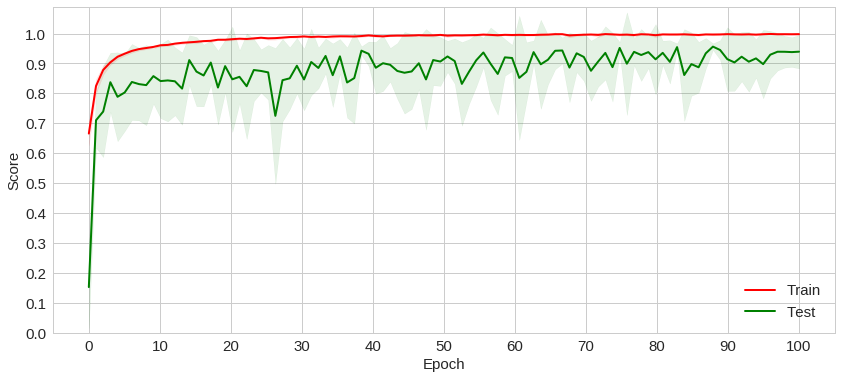

In [37]:
plot_mean_acc(hist)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

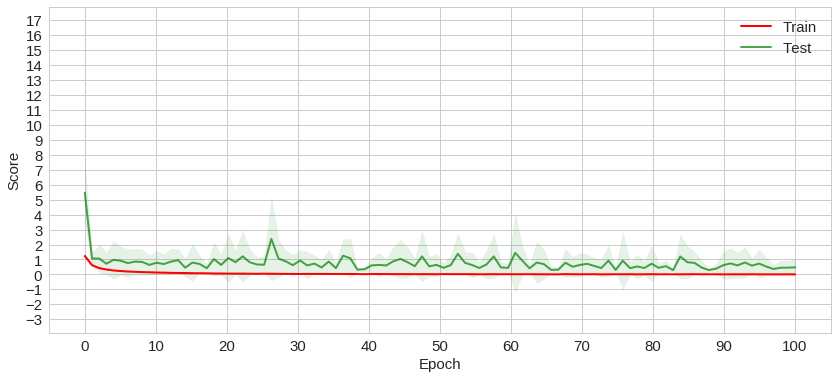

In [39]:
plot_mean_loss(hist)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
        
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.set_xlabel("Epoch", fontsize=text_fontsize)
    ax1.set_ylabel("Accuracy", fontsize=text_fontsize)
    ax1.grid(True)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax1.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax1.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax1.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train acc")
    ax1.plot(epochs, test_scores_mean, '-', color="b", linewidth=2.0, label="Test acc")
    ax1.plot(np.argmax(test_scores_mean)+1, np.max(test_scores_mean), 'o', color="k", label=None)
    ax1.annotate('Max acc: %.4f (Epoch: %d)' %(np.max(test_scores_mean),np.argmax(test_scores_mean)), xy=(np.argmax(test_scores_mean)+1, np.max(test_scores_mean)), xytext=(np.argmax(test_scores_mean)-15, np.max(test_scores_mean)-0.2), arrowprops=dict(facecolor='k', shrink=0.05),)
    ax1.tick_params(labelsize=text_fontsize)
    ax1.legend(loc="lower left", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    ax2 = ax1.twinx()
    ax2.set_xlabel("Epoch", fontsize=text_fontsize)
    ax2.set_ylabel("Loss", fontsize=text_fontsize)
    ax2.grid(False)
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax2.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax2.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="b")
    ax2.plot(epochs, train_scores_mean, '--', color="r", linewidth=2.0, label="Train loss")
    ax2.plot(epochs, test_scores_mean, '--', color="b", linewidth=2.0, label="Test loss")
    ax2.tick_params(labelsize=text_fontsize)
    ax2.legend(loc="lower right", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-1.9,8.9))
    plt.show()

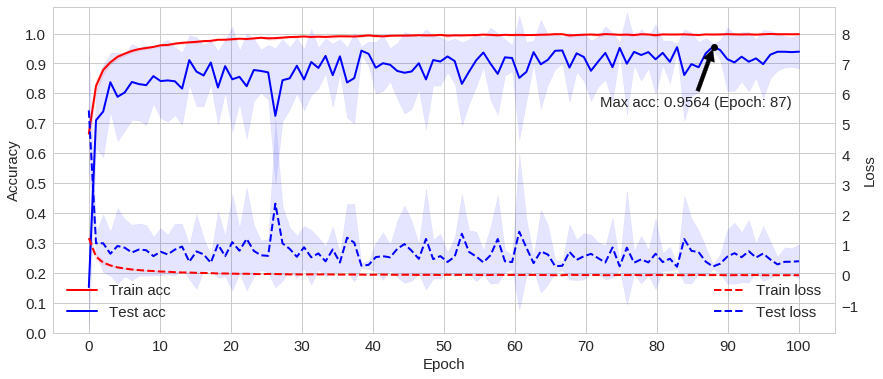

In [41]:
plot_mean(hist)